# Predicting Zillow´s rental price index with historic data

## 1. Import libraries and dataframe.

### 1.1 Import libraries

In [621]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import os
import matplotlib 
from matplotlib import pyplot as plt
import math

### 1.2 Import dataframe

In [622]:
# Import dataframe
os.chdir('C:/Users/Guillermo/Desktop/ESTUDIOS/Data Science Bootcamp/Projects/4. Capstone/Data')
df = pd.read_csv('tampa.csv')

## 2. Data Preprocessing

### 2.1 Split dataframe

#### Split the dataframe between a training and a testing dataframes in order to be able to evaluate our predictions.

In [623]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.loc[:,df.columns != '2017-12'], df['2017-12'], test_size=0.2, random_state = 5)

### 2.2 Missing values

#### In a first exploration we check the number of rows with missing values and the total number of missing values in the training set. This reveals a high number of missing values spread over several variables. Especially, few variables have a high number of missing values. 

#### In order to have a visual representation a plot with the proportion of missing values per variable in the training set is created below.

The number of missing values in the training set is 7961.
The number of rows with missing values in the training set is 998.


Text(0, 0.5, 'Variables')

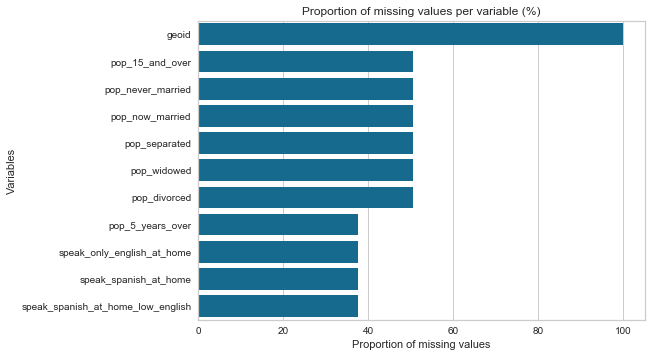

In [624]:
# Total number of missing values in the training set
print('The number of missing values in the training set is {}.'.format(x_train.isna().sum().sum()))

# Total number of rows with missing values. 
print('The number of rows with missing values in the training set is {}.'.format(x_train.shape[0] - x_train.dropna().shape[0]))

# Overview of missing values per variable
df1 = pd.DataFrame(round(((x_train.isna().sum())/x_train.shape[0])*100,2)).reset_index()
df1.rename(columns = {'index':'variables', 0:'missing_values'}, inplace = True)
df1 = df1[df1['missing_values'] > 12].sort_values(ascending = False, by = 'missing_values')
sns.barplot(x = 'missing_values', y = 'variables', data = df1, color = 'b')
plt.title('Proportion of missing values per variable (%)', loc = 'center')
plt.xlabel('Proportion of missing values')
plt.ylabel('Variables')


#### Now, we check the number of rows with missing values and the total number of missing values in the testing set. Again, this reveals a high number of missing values spread over several variables. In addition, we can see that one variable, Electrical, has only one missing value and that it fell in the testing set when the split was done. Therefore, there is an additional feature we have to impute in the testing set in comparison to the training set. 

#### Again, in order to have a visually representation a plot with the proportion of missing values per variable in the testing set is created.

The number of missing values in the testing set is 2155.
The number of rows with missing values in the testing set is 250.


Text(0, 0.5, 'Variables')

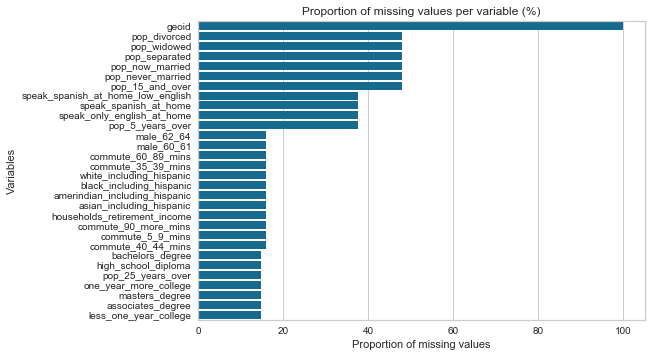

In [625]:
# Total number of missing values in the testing set
print('The number of missing values in the testing set is {}.'.format(x_test.isna().sum().sum()))

# Total number of rows with missing values. 
print('The number of rows with missing values in the testing set is {}.'.format(x_test.shape[0] - x_test.dropna().shape[0]))

# Overview of missing values per variable
df1 = pd.DataFrame(round(((x_test.isna().sum())/x_test.shape[0])*100,2)).reset_index()
df1.rename(columns = {'index':'variables', 0:'missing_values'}, inplace = True)
df1 = df1[df1['missing_values'] > 12].sort_values(ascending = False, by = 'missing_values')
sns.barplot(x = 'missing_values', y = 'variables', data = df1, color = 'b')
plt.title('Proportion of missing values per variable (%)', loc = 'center')
plt.xlabel('Proportion of missing values')
plt.ylabel('Variables')

#### All of our variables are numeric. We imput using the median. We do so trying to keep the imputation as local as possible. We start imputing the median of the city and move to the State for the values that remain missing.
#### We impute in the testing set using the training set as a reference.

In [626]:
missing_values_featues = x_train.isna().sum().reset_index().rename(columns = {0:'missing_values'})
for feature in list(missing_values_featues[missing_values_featues['missing_values'] > 0].iloc[:,0]):
    # We start at the city level
    x_train[feature] = x_train.groupby('City')[feature].transform(lambda x: x.fillna(x.median()))
    for i in range(0, x_test.shape[0]):
        if x_test['City'].iloc[i] in list(x_train['City'].unique()):
            x_test[feature].iloc[i] = x_train.groupby('City')[feature].median()[x_test['City'].iloc[i]]
        else:
            x_test[feature].iloc[i] = x_train[feature].median()
    # Next we move to the state level
    x_train[feature] = x_train.groupby('State')[feature].transform(lambda x: x.fillna(x.median()))
    for i in range(0, x_test.shape[0]):
        if x_test['State'].iloc[i] in list(x_train['State'].unique()):
            x_test[feature].iloc[i] = x_train.groupby('State')[feature].median()[x_test['State'].iloc[i]]
        else:
            x_test[feature].iloc[i] = x_train[feature].median()

#### geoid does not contain relevant information as we can use geo_id instead. Therefore, we drop it.

In [627]:
x_train.drop(columns = ['geoid'], inplace = True)
x_test.drop(columns = ['geoid'], inplace = True)

#### City and State provides no information as all our locations are in Phoenix.

In [628]:
x_train.drop(columns = ['City', 'State'], inplace = True)
x_test.drop(columns = ['City', 'State'], inplace = True)

#### Check the number of missing values in the training and testing sets.

In [629]:
# Total number of missing values in the training set
print('The number of missing values in the training set is {}.'.format(x_train.isna().sum().sum()))
# Total number of rows with missing values. 
print('The number of rows with missing values in the training set is {}.'.format(x_train.shape[0] - x_train.dropna().shape[0]))

print(' ')

# Total number of missing values in the testing set
print('The number of missing values in the testing set is {}.'.format(x_test.isna().sum().sum()))
# Total number of rows with missing values. 
print('The number of rows with missing values in the testing set is {}.'.format(x_test.shape[0] - x_test.dropna().shape[0]))


The number of missing values in the training set is 0.
The number of rows with missing values in the training set is 0.
 
The number of missing values in the testing set is 0.
The number of rows with missing values in the testing set is 0.


### 2.3 Feature engineering

#### In order to check for multicollinearity among our numerical variables, me plot the correlation matrix of our features.

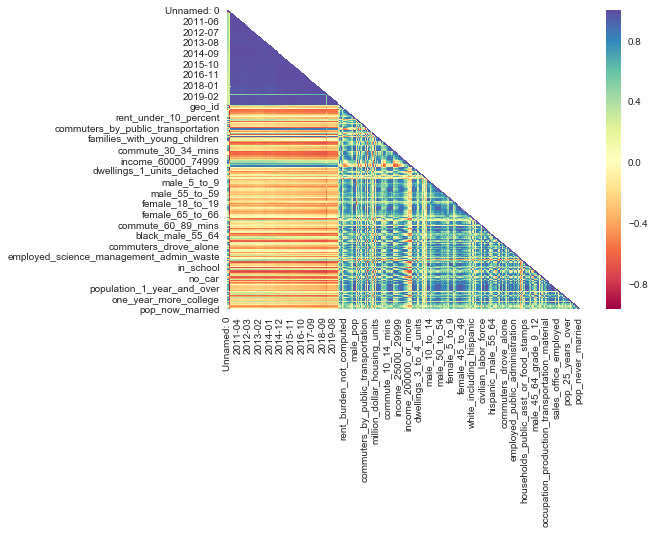

In [630]:
num_features = x_train.select_dtypes(include = ['int64', 'float64'])
corr_x_train =  num_features.corr(method = 'pearson') 
matrix = corr_x_train.where(np.tril(np.ones(corr_x_train.shape)).astype(np.bool))

hmap = sns.heatmap(matrix, cmap = "Spectral")
hmap

#### We now check the variance inflation factor.

In [631]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

num_features = x_train.select_dtypes(include = ['int64', 'float64'])
vif_data = pd.DataFrame() 
vif_data["feature"] = num_features.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(num_features.values, i) 
                          for i in range(len(num_features.columns))] 
  
vif = pd.DataFrame(vif_data).sort_values(by = 'VIF', ascending = False)
print(vif)

C:\Users\Guillermo\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                         feature         VIF
184         income_100000_124999         inf
243              female_50_to_54         inf
252           female_85_and_over         inf
251              female_80_to_84         inf
250              female_75_to_79         inf
..                           ...         ...
121     rent_burden_not_computed         inf
120  median_year_structure_built         inf
119            family_households         inf
118         nonfamily_households         inf
0                     Unnamed: 0  172.958212

[369 rows x 2 columns]


#### Location variables: since all our zipcodes are in Phoenix, variables providing information about the city, state, metro or county don´t provide any extra information. Therefore, we drop them.

In [632]:
x_train.drop(columns = ['Metro', 'CountyName', 'RegionID'], inplace = True)
x_test.drop(columns = ['Metro', 'CountyName', 'RegionID'], inplace = True)

#### do_date doesn´t provide any information about the dependent variable. Therefore, we drop it.

In [633]:
x_train.drop(columns = ['do_date'], inplace = True)
x_test.drop(columns = ['do_date'], inplace = True)

#### Unnamed is an index variable that it´s not necessary. Therefore, we drop it

In [634]:
x_train.drop(columns = ['Unnamed: 0'], inplace = True)
x_test.drop(columns = ['Unnamed: 0'], inplace = True)

#### SizeRank is just an ordering of size. We drop it.

In [635]:
x_train.drop(columns = ['SizeRank'], inplace = True)
x_test.drop(columns = ['SizeRank'], inplace = True)

#### RegionName is not a variable that we are going to use to predict as geo_id contains the same information.

In [636]:
x_train.drop(columns = ['RegionName'], inplace = True)
x_test.drop(columns = ['RegionName'], inplace = True)

#### year is not a variable that we are using to predict. Therefore, we drop it.

In [637]:
x_train.drop(columns = ['year'], inplace = True)
x_test.drop(columns = ['year'], inplace = True)

#### Grouping female age columns together

In [638]:
# x_train
x_train['female_under_18'] = x_train.female_under_5 + x_train.female_5_to_9 + x_train.female_10_to_14 + x_train.female_15_to_17 + x_train.female_18_to_19
x_train['female_under_60'] = x_train.female_20 + x_train.female_21 + x_train.female_22_to_24 + x_train.female_25_to_29 + x_train.female_30_to_34 + x_train.female_35_to_39 + x_train.female_40_to_44 + x_train.female_45_to_49 + x_train.female_50_to_54 + x_train.female_55_to_59 
x_train['female_over_60'] = x_train.female_60_to_61 + x_train.female_62_to_64 + x_train.female_65_to_66 + x_train.female_67_to_69 + x_train.female_70_to_74 + x_train.female_75_to_79 + x_train.female_80_to_84 + x_train.female_85_and_over

In [639]:
# x_test
x_test['female_under_18'] = x_test.female_under_5 + x_test.female_5_to_9 + x_test.female_10_to_14 + x_test.female_15_to_17 + x_test.female_18_to_19
x_test['female_under_60'] = x_test.female_20 + x_test.female_21 + x_test.female_22_to_24 + x_test.female_25_to_29 + x_test.female_30_to_34 + x_test.female_35_to_39 + x_test.female_40_to_44 + x_test.female_45_to_49 + x_test.female_50_to_54 + x_test.female_55_to_59 
x_test['female_over_60'] = x_test.female_60_to_61 + x_test.female_62_to_64 + x_test.female_65_to_66 + x_test.female_67_to_69 + x_test.female_70_to_74 + x_test.female_75_to_79 + x_test.female_80_to_84 + x_test.female_85_and_over

#### Grouping male age columns together

In [640]:
# x_train
x_train['male_under_18'] = x_train.male_under_5 + x_train.male_5_to_9 + x_train.male_10_to_14 + x_train.male_15_to_17 + x_train.male_18_to_19
x_train['male_under_60'] = x_train.male_20 + x_train.male_21 + x_train.male_22_to_24 + x_train.male_25_to_29 + x_train.male_30_to_34 + x_train.male_35_to_39 + x_train.male_40_to_44 + x_train.male_45_to_49 + x_train.male_50_to_54 + x_train.male_55_to_59 
x_train['male_over_60'] = x_train.male_60_61 + x_train.male_62_64 + x_train.male_65_to_66 + x_train.male_67_to_69 + x_train.male_70_to_74 + x_train.male_75_to_79 + x_train.male_80_to_84 + x_train.male_85_and_over

In [641]:
# x_test
x_test['male_under_18'] = x_test.male_under_5 + x_test.male_5_to_9 + x_test.male_10_to_14 + x_test.male_15_to_17 + x_test.male_18_to_19
x_test['male_under_60'] = x_test.male_20 + x_test.male_21 + x_test.male_22_to_24 + x_test.male_25_to_29 + x_test.male_30_to_34 + x_test.male_35_to_39 + x_test.male_40_to_44 + x_test.male_45_to_49 + x_test.male_50_to_54 + x_test.male_55_to_59 
x_test['male_over_60'] = x_test.male_60_61 + x_test.male_62_64 + x_test.male_65_to_66 + x_test.male_67_to_69 + x_test.male_70_to_74 + x_test.male_75_to_79 + x_test.male_80_to_84 + x_test.male_85_and_over

#### Grouping rent affordability columns together

In [642]:
# x_train
x_train['under10'] = x_train.rent_under_10_percent
x_train['tento50'] = x_train.rent_40_to_50_percent + x_train.rent_35_to_40_percent + x_train.rent_30_to_35_percent+ x_train.rent_25_to_30_percent + x_train.rent_20_to_25_percent + x_train.rent_15_to_20_percent +x_train.rent_10_to_15_percent
x_train['over50'] = x_train.rent_over_50_percent
x_train['uncomputed'] = x_train.rent_burden_not_computed

In [643]:
# x_test
x_test['under10'] = x_test.rent_under_10_percent
x_test['tento50'] = x_test.rent_40_to_50_percent + x_test.rent_35_to_40_percent + x_test.rent_30_to_35_percent+ x_test.rent_25_to_30_percent + x_test.rent_20_to_25_percent + x_test.rent_15_to_20_percent + x_test.rent_10_to_15_percent
x_test['over50'] = x_test.rent_over_50_percent
x_test['uncomputed'] = x_test.rent_burden_not_computed

#### Grouping dwellings columns together

In [644]:
# x_train
x_train['small_dwellings'] = x_train.dwellings_1_units_attached + x_train.dwellings_1_units_detached + x_train.dwellings_2_units + x_train.dwellings_3_to_4_units + x_train.dwellings_5_to_9_units
x_train['large_dwellings'] = x_train.dwellings_10_to_19_units + x_train.dwellings_20_to_49_units + x_train.dwellings_50_or_more_units

In [645]:
# x_test
x_test['small_dwellings'] = x_test.dwellings_1_units_attached + x_test.dwellings_1_units_detached + x_test.dwellings_2_units + x_test.dwellings_3_to_4_units + x_test.dwellings_5_to_9_units
x_test['large_dwellings'] = x_test.dwellings_10_to_19_units + x_test.dwellings_20_to_49_units + x_test.dwellings_50_or_more_units

#### Grouping commute time together

In [646]:
# x_train
x_train['commute_less_than_30'] = x_train.commute_5_9_mins + x_train.commute_less_10_mins + x_train.commute_10_14_mins + x_train.commute_15_19_mins + x_train.commute_20_24_mins + x_train.commute_25_29_mins
x_train['commute_less_than_60'] = x_train.commute_30_34_mins + x_train.commute_35_39_mins + x_train.commute_35_44_mins + x_train.commute_40_44_mins + x_train.commute_45_59_mins
x_train['commute_over_60'] = x_train.commute_60_89_mins + x_train.commute_60_more_mins + x_train.commute_90_more_mins

In [647]:
# x_test
x_test['commute_less_than_30'] = x_test.commute_5_9_mins + x_test.commute_less_10_mins + x_test.commute_10_14_mins + x_test.commute_15_19_mins + x_test.commute_20_24_mins + x_test.commute_25_29_mins
x_test['commute_less_than_60'] = x_test.commute_30_34_mins + x_test.commute_35_39_mins + x_test.commute_35_44_mins + x_test.commute_40_44_mins + x_test.commute_45_59_mins
x_test['commute_over_60'] = x_test.commute_60_89_mins + x_test.commute_60_more_mins + x_test.commute_90_more_mins

#### Grouping income levels together

In [648]:
# x_train
x_train['income_less_than_60000'] = x_train.income_less_10000 + x_train.income_10000_14999 + x_train.income_15000_19999 + x_train.income_20000_24999 + x_train.income_25000_29999 + x_train.income_30000_34999 + x_train.income_35000_39999 + x_train.income_40000_44999 + x_train.income_45000_49999 + x_train.income_50000_59999
x_train['income_less_than_125000'] = x_train.income_60000_74999 + x_train.income_75000_99999 + x_train.income_100000_124999
x_train['income_over_125000'] = x_train.income_125000_149999 + x_train.income_150000_199999 + x_train.income_200000_or_more

In [649]:
# x_test
x_test['income_less_than_60000'] = x_test.income_less_10000 + x_test.income_10000_14999 + x_test.income_15000_19999 + x_test.income_20000_24999 + x_test.income_25000_29999 + x_test.income_30000_34999 + x_test.income_35000_39999 + x_test.income_40000_44999 + x_test.income_45000_49999 + x_test.income_50000_59999
x_test['income_less_than_125000'] = x_test.income_60000_74999 + x_test.income_75000_99999 + x_test.income_100000_124999
x_test['income_over_125000'] = x_test.income_125000_149999 + x_test.income_150000_199999 + x_test.income_200000_or_more

#### Grouping employment industries together

In [650]:
# x_train
x_train['employed_creative'] = x_train.employed_arts_entertainment_recreation_accommodation_food
x_train['employed_prof'] = x_train.employed_education_health_social + x_train.employed_finance_insurance_real_estate + x_train.employed_information + x_train.employed_science_management_admin_waste
x_train['employed_skill'] = x_train.employed_manufacturing + x_train.employed_construction + x_train.employed_agriculture_forestry_fishing_hunting_mining
x_train['employed_service'] = x_train.employed_retail_trade + x_train.employed_other_services_not_public_admin + x_train.employed_public_administration + x_train.employed_transportation_warehousing_utilities + x_train.employed_wholesale_trade

In [651]:
# x_test
x_test['employed_creative'] = x_test.employed_arts_entertainment_recreation_accommodation_food
x_test['employed_prof'] = x_test.employed_education_health_social + x_test.employed_finance_insurance_real_estate + x_test.employed_information + x_test.employed_science_management_admin_waste
x_test['employed_skill'] = x_test.employed_manufacturing + x_test.employed_construction + x_test.employed_agriculture_forestry_fishing_hunting_mining
x_test['employed_service'] = x_test.employed_retail_trade + x_test.employed_other_services_not_public_admin + x_test.employed_public_administration + x_test.employed_transportation_warehousing_utilities + x_test.employed_wholesale_trade

#### Choosing family type columns

In [652]:
# x_train
x_train['two_parent_hh'] = x_train.two_parent_families_with_young_children.astype(float)
x_train['one_parent_hh'] = x_train.one_parent_families_with_young_children.astype(float)

In [653]:
# x_test
x_test['two_parent_hh'] = x_test.two_parent_families_with_young_children.astype(float)
x_test['one_parent_hh'] = x_test.one_parent_families_with_young_children.astype(float)

In [654]:
#pop_columns = [asian_pop, amerindian_pop, black_pop, hispanic_pop, white_pop, amerindian_including_hispanic,other_race_pop,two_or_more_races_pop]

#### Grouping education level columns together

In [655]:
# x_train
x_train['college_educated'] = x_train.in_undergrad_college + x_train.some_college_and_associates_degree + x_train.associates_degree + x_train.bachelors_degree + x_train.bachelors_degree_2 + x_train.bachelors_degree_or_higher_25_64 + x_train.masters_degree + x_train.graduate_professional_degree + x_train.one_year_more_college     
x_train['in_school'] = x_train.in_grades_1_to_4 + x_train.in_grades_5_to_8 + x_train.in_grades_9_to_12
x_train['inschoolcheck'] = x_train.in_school
x_train['less_than_college_educated'] = x_train.less_one_year_college + x_train.less_one_year_college
x_train['high_school_educated'] = x_train.high_school_diploma + x_train.high_school_including_ged

In [656]:
# x_test
x_test['college_educated'] = x_test.in_undergrad_college + x_test.some_college_and_associates_degree + x_test.associates_degree + x_test.bachelors_degree + x_test.bachelors_degree_2 + x_test.bachelors_degree_or_higher_25_64 + x_test.masters_degree + x_test.graduate_professional_degree + x_test.one_year_more_college     
x_test['in_school'] = x_test.in_grades_1_to_4 + x_test.in_grades_5_to_8 + x_test.in_grades_9_to_12
x_test['inschoolcheck'] = x_test.in_school
x_test['less_than_college_educated'] = x_test.less_one_year_college + x_test.less_one_year_college
x_test['high_school_educated'] = x_test.high_school_diploma + x_test.high_school_including_ged

#### Grouping commute type columns together

In [657]:
# x_train
x_train['public_commute'] = x_train.commuters_by_public_transportation + x_train.commuters_by_subway_or_elevated + x_train.commuters_by_bus
x_train['personal_commute'] = x_train.commuters_by_car_truck_van + x_train.commuters_by_carpool + x_train.commuters_drove_alone

In [658]:
# x_test
x_test['public_commute'] = x_test.commuters_by_public_transportation + x_test.commuters_by_subway_or_elevated + x_test.commuters_by_bus
x_test['personal_commute'] = x_test.commuters_by_car_truck_van + x_test.commuters_by_carpool + x_test.commuters_drove_alone

In [659]:
x_train = x_train[['2015-12','gini_index', 'income_per_capita', 'median_age', 'median_income', 'married_households', 'family_households', 
                   'nonfamily_households', 'unemployed_pop', 'employed_pop', 'owner_occupied_housing_units',
                   'owner_occupied_housing_units_lower_value_quartile','owner_occupied_housing_units_median_value',
                   'owner_occupied_housing_units_upper_value_quartile','vacant_housing_units', 'vacant_housing_units_for_rent',
                   'vacant_housing_units_for_sale', 'public_commute', 'personal_commute','college_educated', 'in_school', 
                   'less_than_college_educated','high_school_educated', 'asian_pop', 'amerindian_pop', 'black_pop',
                   'hispanic_pop', 'white_pop', 'amerindian_including_hispanic', 'other_race_pop', 'two_or_more_races_pop', 
                   'two_parent_hh', 'one_parent_hh', 'employed_creative', 'employed_prof', 'employed_skill','employed_service', 
                   'income_less_than_60000', 'income_less_than_125000','income_over_125000', 'commute_less_than_30', 
                   'commute_less_than_60','commute_over_60', 'small_dwellings', 'large_dwellings', 'male_under_18',
                   'male_under_60', 'male_over_60', 'female_under_18', 'female_under_60','female_over_60']]

In [660]:
x_test = x_test[['2015-12','gini_index', 'income_per_capita', 'median_age', 'median_income', 'married_households', 'family_households', 
                   'nonfamily_households', 'unemployed_pop', 'employed_pop', 'owner_occupied_housing_units',
                   'owner_occupied_housing_units_lower_value_quartile','owner_occupied_housing_units_median_value',
                   'owner_occupied_housing_units_upper_value_quartile','vacant_housing_units', 'vacant_housing_units_for_rent',
                   'vacant_housing_units_for_sale', 'public_commute', 'personal_commute','college_educated', 'in_school', 
                   'less_than_college_educated','high_school_educated', 'asian_pop', 'amerindian_pop', 'black_pop',
                   'hispanic_pop', 'white_pop', 'amerindian_including_hispanic', 'other_race_pop', 'two_or_more_races_pop', 
                   'two_parent_hh', 'one_parent_hh', 'employed_creative', 'employed_prof', 'employed_skill','employed_service', 
                   'income_less_than_60000', 'income_less_than_125000','income_over_125000', 'commute_less_than_30', 
                   'commute_less_than_60','commute_over_60', 'small_dwellings', 'large_dwellings', 'male_under_18',
                   'male_under_60', 'male_over_60', 'female_under_18', 'female_under_60','female_over_60']]

#### Change the format of our numeric variables to float

In [661]:
for feature in x_train.columns:
    x_train[feature] = x_train[feature].astype(float)
for feature in x_train.columns:
    x_train[feature] = x_train[feature].astype(float)    

#### Check multicollinearity again.

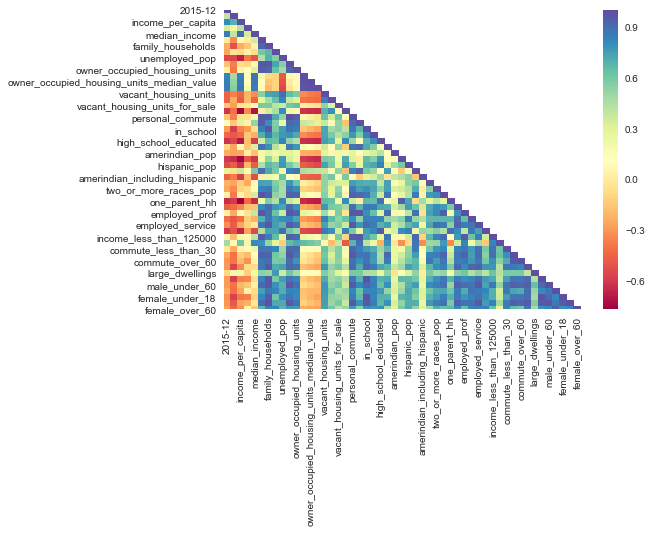

In [662]:
num_features = x_train.select_dtypes(include = ['int64', 'float64'])
corr_x_train =  num_features.corr(method = 'pearson') 
matrix = corr_x_train.where(np.tril(np.ones(corr_x_train.shape)).astype(np.bool))

hmap = sns.heatmap(matrix, cmap = "Spectral")
hmap

### 2.4 Outlier detection

#### In order to detect outliers Cook´s distance is implemented. The observations that are signal out are appended to a list. We also try to identify outliers by checking whether they fall out of the inter quantile range (IQR). These outliers are also appended to a different list. Afterwards, we decide to drop the outliers that appear in both lists. The reason we follow this approach is that the Cook´s distance assumes an ordinary least square regression in order to identify outliers. Given that we also plan to implement different linear models (lasso and ridge in particular), it was decided to also use the IQR.

#### IQR outlier detection.

In [663]:
train = pd.concat([y_train, x_train], axis = 1)

# Define a function that will detect outliers according to the following boundaries:
def outlier_detection(feature): 
    sorted(feature) 
    q1,q3 = np.percentile(feature , [25,75]) 
    IQR = q3 - q1 
    lower_range = q1 - (3 * IQR) 
    upper_range = q3 + (3 * IQR) 
    return lower_range,upper_range

# Apply the function above to all numerical variables in the dataframe. Outliers found for every variable will be stored
# in a list and then append it to a nested list that contains all of the outlier´s indexes (so one list per variable within
# the nested list).
num_features = train.select_dtypes(include = ['number']).columns
outliers = {}
list_outliers = []
for feature in num_features:
    outlier_detection(train[feature])
    lower_range, upper_range = outlier_detection(train[feature])
    overall_qual_drop = train[(train[feature] < lower_range) | (train[feature] > upper_range)]
    outliers[feature] = list(overall_qual_drop.index)
    list_outliers.append(list(overall_qual_drop.index))

# Flatten the nested list so that we have a list with all the outliers´ indexes detected for each variable.
flat_list = []
for sublist in list_outliers:
    for item in sublist:
        flat_list.append(item)

# Create a dictinary with the counts of every outlier, so that we know how many times a single observation has been 
# classified as an outlier. We then sort the dictionary by descending order.
repeated_outliers = {i: flat_list.count(i) for i in flat_list}
repeated_outliers = sorted(repeated_outliers.items(), key = lambda x: x[1], reverse = True)

# We plot the output:
print('Number of times an observation is classified as an outlier:')
print('  ')
print('Nº       Index')
for index, outliers in repeated_outliers:
    print('{}        {}'.format(outliers, index))

Number of times an observation is classified as an outlier:
  
Nº       Index
8        86
8        22
8        62
8        6
8        30
8        46
8        70
8        54
8        38
8        94
8        14
8        78
7        87
7        47
7        55
7        39
7        79
7        63
7        31
7        60
7        12
7        13
7        37
7        84
7        93
7        4
7        52
7        21
7        61
7        77
7        53
7        68
7        75
7        91
7        69
7        43
7        76
7        83
7        92
7        19
7        67
7        20
7        29
7        36
7        44
7        5
7        27
6        42
6        66
6        26
6        2
6        10
6        90
6        18
6        58
6        74
6        82
5        33
5        89
5        49
5        25
5        1
5        65
5        9
5        81
5        17
5        41
5        73
3        8
3        64
3        56
3        48
3        16
3        0
3        88
3        24
2        131
2    

In [664]:
outlier_index = []
for i in range(0,30):
    outlier_index.append(repeated_outliers[i][0])
print('The outliers to be removed from the dataframe are {}'.format(outlier_index))

The outliers to be removed from the dataframe are [86, 22, 62, 6, 30, 46, 70, 54, 38, 94, 14, 78, 87, 47, 55, 39, 79, 63, 31, 60, 12, 13, 37, 84, 93, 4, 52, 21, 61, 77]


#### Cook´s distance outlier detection.

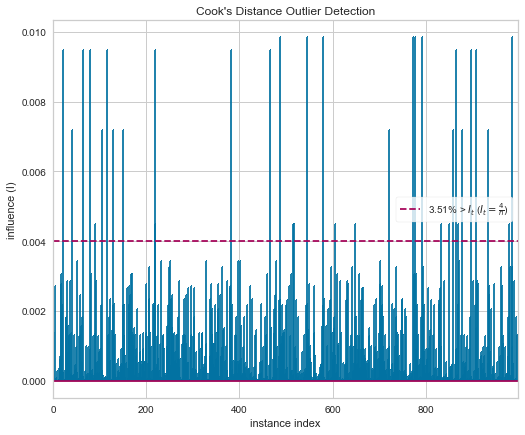

In [665]:
from yellowbrick.base import Visualizer
from yellowbrick.regressor import CooksDistance
visualizer = CooksDistance(size = (600, 500))
z = x_train.select_dtypes(include = ['int64', 'float64'])
visualizer.fit(z, y_train)
visualizer.poof()

In [666]:
outliers = visualizer.distance_ >= visualizer.influence_threshold_
outliers = list(outliers[outliers == True].index)

outlier = []
for i in range(1,len(outliers)):
    if outliers[i] in outlier_index:
               outlier.append(outliers[i])

In [667]:
x_train.drop(index = outlier, inplace = True)
y_train.drop(index = outlier, inplace = True) 

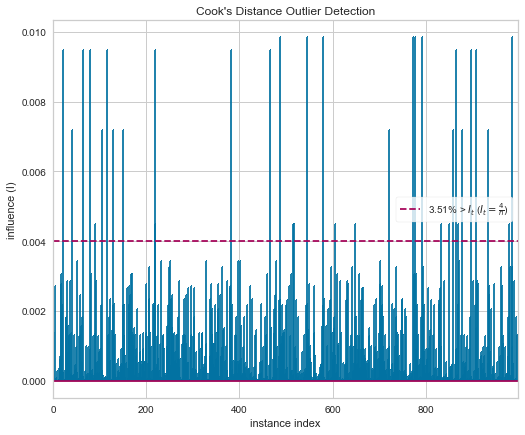

In [668]:
visualizer = CooksDistance(size = (600, 500))
z = x_train.select_dtypes(include = ['int64', 'float64'])
visualizer.fit(z, y_train)
visualizer.poof()

### 2.5 Yeo-Johnson transformation

#### Before implementing any transformation, we plot the distribution of our numerical variables:

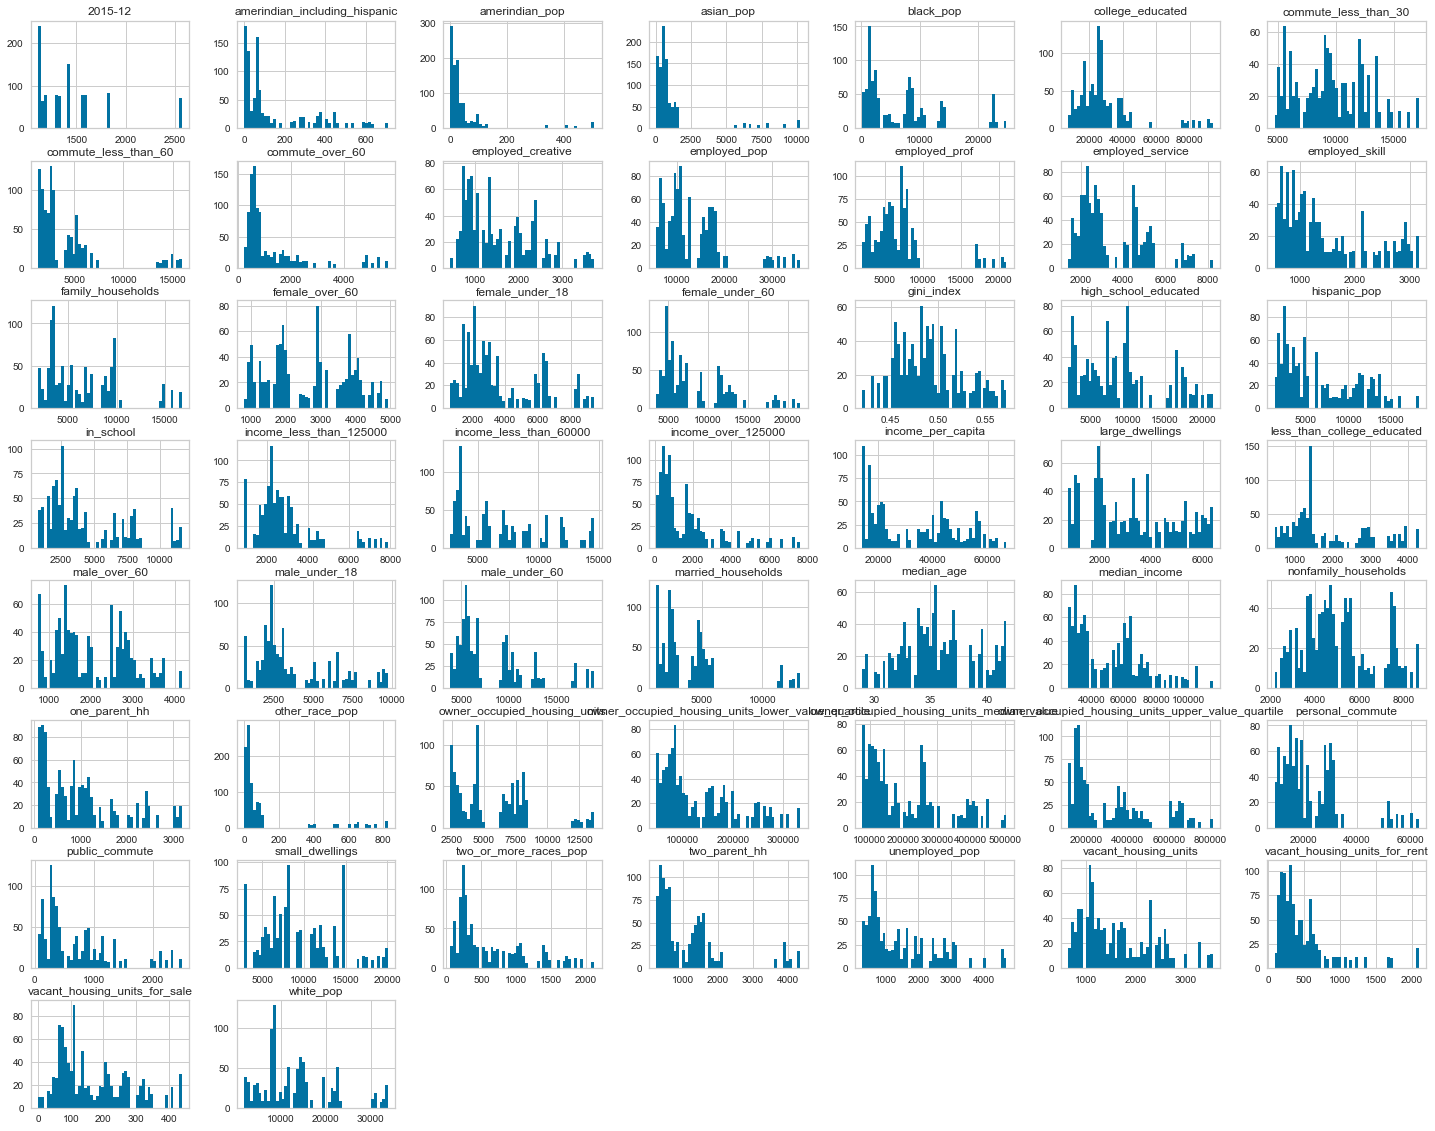

In [669]:
x_train.select_dtypes(include = ['int64', 'float64']).hist(bins = 50, figsize = (25,20))
plt.show()

#### We can see how the continuous numerical variables are right skewed. In order to correct for this, we try a yeo-johnson transformation to normalize our features. There are three reasons why the yeo-johnson transformation is chosen: 
#### 1. Many of our features we have zero values and the box-cox transformation demands strictly positives values.
#### 2. Yeo-johnson tranformation allows to train in the training data and then apply to the testing data. Therefore, it keeps the rigour we need to keep to then realistically evaluate our model. 
#### 3. Yeo-johnson transformation also scales the data and centers it around zero.

In [670]:
from sklearn.preprocessing import PowerTransformer
    
pt = PowerTransformer(method = 'yeo-johnson')
for feature in list(x_train.select_dtypes(include = ['int64', 'float64'])):
    x_train[feature] = pt.fit_transform(x_train[feature].to_numpy().reshape(-1,1))
    x_test[feature] = pt.transform(x_test[feature].to_numpy().reshape(-1,1))    

C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.

#### We now check how the yeo-johnson transformation scaled and normalized our data. 

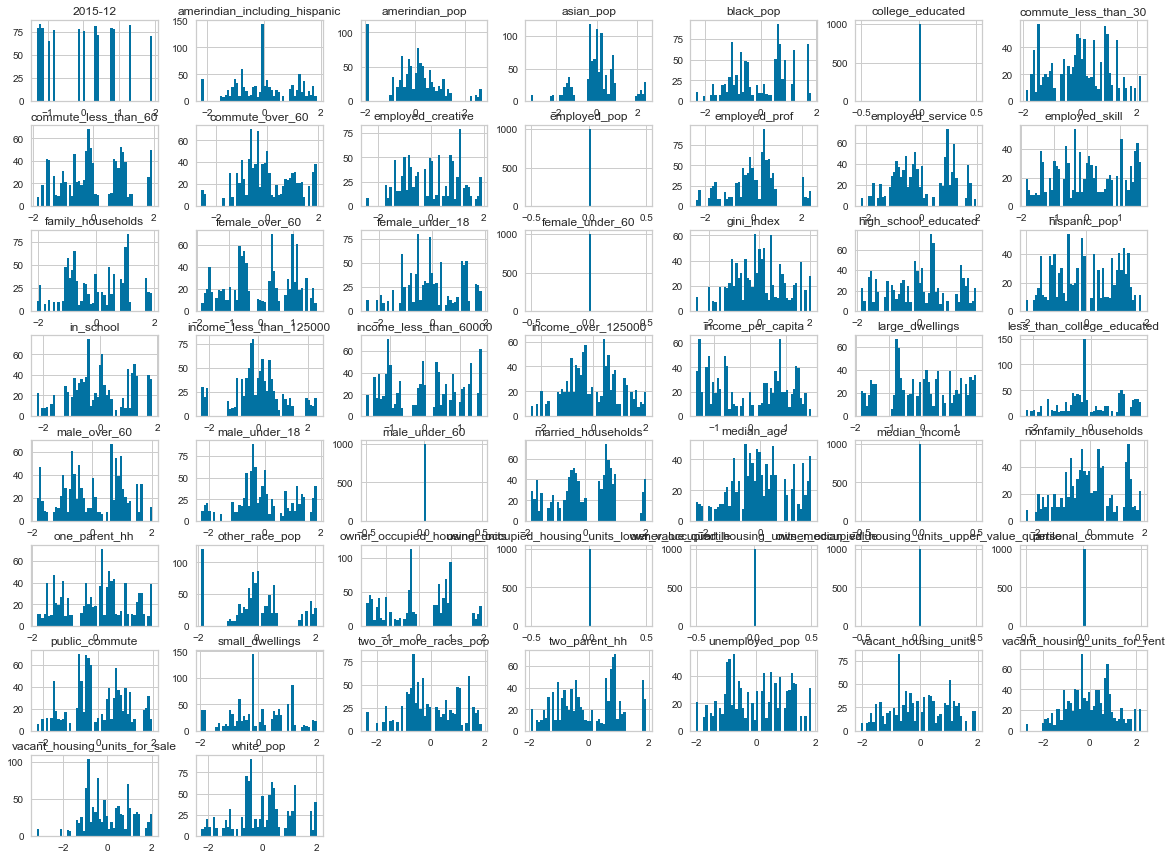

In [671]:
x_train.select_dtypes(include = ['int64', 'float64']).hist(bins = 50, figsize = (20,15))
plt.show()

### 2.5 Target variable´s logarithmic transformation 

#### The distribution of the dependent variables is right skewed. This will be a problem when implementing linear models. 

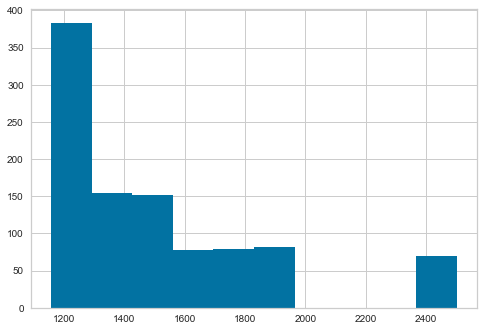

In [672]:
y_train.hist()

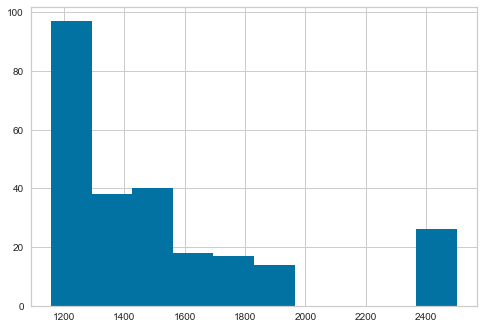

In [673]:
y_test.hist()

#### Because of this reason, we perform a logarithmic transformation on the dependent variable. We then check that it is now normally distributed in both the training and testing datasets.

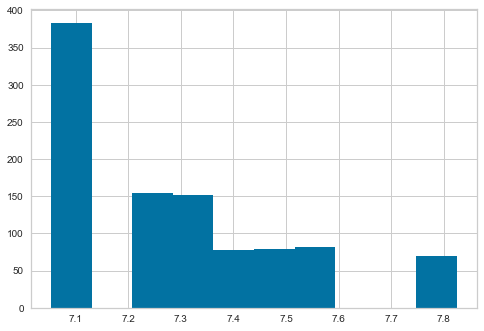

In [674]:
# We apply the logarithmic transformation.
y_train = y_train.apply(lambda x: np.log(x))

# We check the new dependent variable´s distribution.
y_train.hist() 

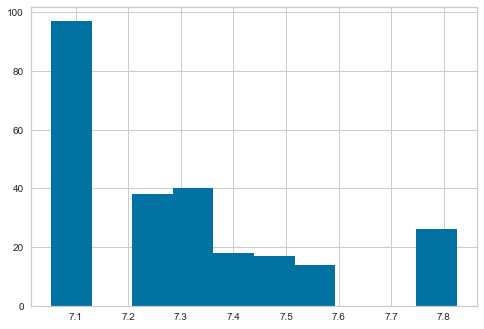

In [675]:
# We apply the logarithmic transformation.
y_test = y_test.apply(lambda x: np.log(x))

# We check the new dependent variable´s distribution.
y_test.hist() 

## 3. Lasso Regression

#### As explained before, our multiple linear regression model suffers from multicollinearity. In order to solve this problem we move on to try regression models with regularization properties. In the first place, we try the lasso regression. The steps to follow are:
#### 1. We implement the lasso regression model and check the R-squared for the training and testing dataframes and the degree of regularization in the model. 
#### 2. We tune the hyperparameters using cross-validation and use them to fit a new model, thus trying to find the right balance between accuracy and variance of the model, avoiding over-fitting.
#### 3. Test linear models assumptions.
#### 4. Generate a prediction using our model and comparing it to the testing dataset (y_test) to evaluate its accuracy.  

### 3.1 Implement the lasso regression model

In [676]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(x_train, y_train)

# Check the model´s performance.
print('Training set R-squared is {}'.format(lasso.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(lasso.score(x_test, y_test)))
print('Amount of penalization is {}'.format(lasso.alpha))
# WOULD YOU PUT THIS TOGETHER OR PUT THE CHECK PERFORMANCE IN A DIFFERENT CELL? HOW TO BEST STRUCTURE THE CHUNKS? 
# Separate and leave markdown comment.

Training set R-squared is 0.0
Testing set R-squared is -0.0014154149799583404
Amount of penalization is 1.0


### 3.2 Tune the hyperparameters using cross-validation and fit a new model

In [677]:
from sklearn.linear_model import LassoCV
cv_lasso = LassoCV(n_alphas = 200, cv = 10, max_iter = 1500, fit_intercept = True) 
cv_lasso.fit(x_train, y_train)

# HOW AM I GETTING WORSE PERFORMANCE WITH CROSS-VALIDATION?

# Check Lasso´s performance and best parameters as outcomes of cross validation.
print('Training set R-squared is {}'.format(cv_lasso.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_lasso.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_lasso.alpha_))

Training set R-squared is 0.9949419761910346
Testing set R-squared is 0.9957283864164458
Amount of penalization is 0.00020620006020732897


C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017028048919200955, tolerance: 0.004574001950254744
  positive)


### 3.3 Test linear model assumptions

#### 1. Homoskedasticity assumption. 

#### We run a bartlett test by splitting the residual´s array into two different arrays to test if they have the same variance (bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances).

#### We also plot the residuals plot to have a visual representation of the residuals distribution and check whether there is heteroskedasticity. 

The bartlett test´s statistics is 0.05398189653719618 and the p-value is 0.81627391182279


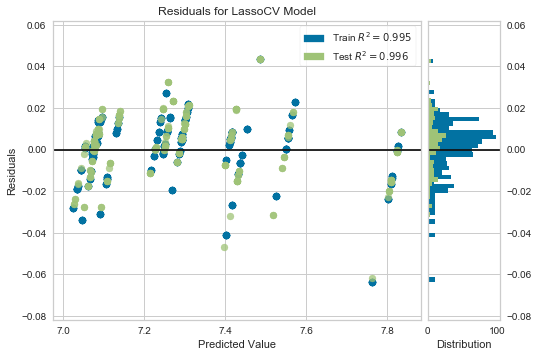

In [678]:
# Bartlett’s test
residuals = cv_lasso.predict(x_test) - y_test

split_array = np.split(residuals, 2)
sample1 = split_array[0]
sample2 = split_array[1]

from scipy import stats
import scipy.stats
bartlett = stats.bartlett(sample1, sample2)
print('The bartlett test´s statistics is {} and the p-value is {}'.format(bartlett[0], bartlett[1]))

# Plot residuals
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(cv_lasso)

# Fit the training data to the visualizer
visualizer.fit(x_train, y_train)  
# Evaluate the model on the test data
visualizer.score(x_test, y_test)  
# Finalize and render the figure
visualizer.show()

#### The plot allows us to check that there is not heteroskedasticity. In addition, the bartlett’s test p_value does not suffice to reject the null hypothesis (equal variances). Therefore, we can conclude that the homoskedasticity assumption holds. 

#### 2. Normality of the residuals assumption



#### In order to check normality a Q-Q plot is visualized below. Also, a battery of normality test are run: Jarque-Bera test, Shapiro-Wilk test, Anderson-Darling test and the Kolmogorov-Smirnov test.

Jarque_bera statistic is 24.659583090607324 and the p-value is 4.418140970297024e-06
Shapiro-Wilk statistic is 0.975568413734436 and the p-value is 0.00026665214681997895
Anderson-Darling statistic is 1.4839797097711767 and the p-values are [0.567 0.646 0.775 0.904 1.075]
Kolmogorov-Smirnov statistic is 0.4825318242292319 and the p-value is 4.331696196187369e-54


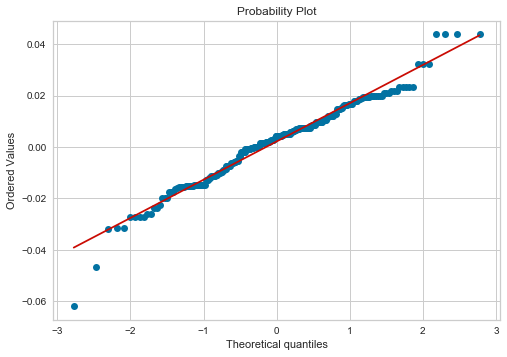

In [679]:
from scipy import stats
# Jarque_bera test
jb = stats.jarque_bera(residuals)
print('Jarque_bera statistic is {} and the p-value is {}'.format(jb[0], jb[1]))
# Shapiro-Wilk test
sw = stats.shapiro(residuals)
print('Shapiro-Wilk statistic is {} and the p-value is {}'.format(sw[0], sw[1]))
# Anderson-Darling test
ad = stats.anderson(residuals, dist = 'norm')
print('Anderson-Darling statistic is {} and the p-values are {}'.format(ad[0], ad[1]))
# Kolmogorov-Smirnov test
ks = stats.kstest(residuals, 'norm')
print('Kolmogorov-Smirnov statistic is {} and the p-value is {}'.format(ks[0], ks[1]))

# Plot Q-Q graph
import pylab 
import scipy.stats as stats
stats.probplot(residuals, dist = "norm", plot = pylab)
pylab.show()

#### The plot shows that the residuals don´t follow an exact normal distribution. The battery of tests confirm this result. The fact that the normality assumptions does not hold should make us skeptical of the reliability of the model. Because of this reason, we will compare the predictions of the model against the y_test prices we are trying to predict. 

#### 3. Independence of the residuals assumption





#### Same as with the multiple linear regression model, a Durbin-Watson test is implemented to evaluate whether the residuals are indepentent.

In [680]:
from statsmodels.stats.stattools import durbin_watson

db = durbin_watson(residuals, axis = 0)

print('The Durbin_Watson statistics is {}'.format(db))

The Durbin_Watson statistics is 2.053652115204151


#### From the result above we can conclude that our residuals are independent. 

### 3.4 Generate and evaluate the prediction

#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [681]:
# Predict SalePrices with the model.
prediction = cv_lasso.predict(x_test)

# Check accuracy with MSE
from sklearn.metrics import mean_squared_error
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
from sklearn.metrics import mean_absolute_error
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.0002284081088050638
The root mean squared error (RMSE) is 0.015113176661611013
The mean absolute error (MAE) is 0.011755709123263063


## 4. Ridge Regression

#### Ridge regression is another linear model that allows regularization. We follow the same steps as before when implementing lasso: 
#### 1. Implement the ridge regression model, check the R-squared for the training and testing dataframes and the degree of regularization in the model. 
#### 2. Tune the hyperparameters using cross-validation and use them to fit a new model.
#### 3. Evaluate wether the linear regression assumptions hold.
#### 4. Generate a prediction using our model and comparing it to the testing dataset (y_test) to evaluate its accuracy.  

### 4.1 Implement the ridge model

In [682]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(x_train, y_train)

# Check the model´s performance
print('Training set R-squared is {}'.format(ridge.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(ridge.score(x_test, y_test)))
print('Amount of penalization is {}'.format(ridge.alpha))

Training set R-squared is 0.9966075684188278
Testing set R-squared is 0.9948096751173668
Amount of penalization is 1.0


### 4.2 Tune the hyperparameters using cross-validation

In [683]:
from sklearn.linear_model import RidgeCV
cv_ridge = RidgeCV(alphas = np.linspace(8, 100, 100), cv = 3, normalize = False, fit_intercept = True)
cv_ridge.fit(x_train, y_train)

# Check Ridge best parameters as outcomes of cross validation.
print('Training set R-squared is {}'.format(cv_ridge.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_ridge.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_ridge.alpha_))

Training set R-squared is 0.9935403273929024
Testing set R-squared is 0.9932195723740163
Amount of penalization is 8.0


### 4.3 Evaluate linear models assumptions

#### 1. Homoskedasticity assumption. 

#### We run a bartlett test by splitting the residual´s array into two different arrays to test if they have the same variance (bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances).

#### We also plot the residuals plot to have a visual representation of the residuals distribution and check whether there is heteroskedasticity. 

The bartlett test´s statistics is 0.6326170781220676 and the p-value is 0.42639697442659485


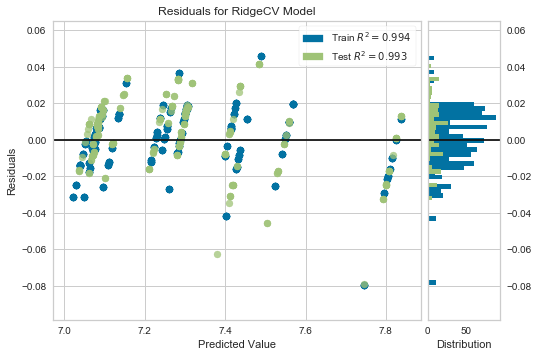

In [684]:
# Bartlett’s test
residuals = cv_ridge.predict(x_test) - y_test

split_array = np.split(residuals, 2)
sample1 = split_array[0]
sample2 = split_array[1]

import scipy.stats
bartlett = stats.bartlett(sample1, sample2)
print('The bartlett test´s statistics is {} and the p-value is {}'.format(bartlett[0], bartlett[1]))

# Plot residuals
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(cv_ridge)

# Fit the training data to the visualizer
visualizer.fit(x_train, y_train)  
# Evaluate the model on the test data
visualizer.score(x_test, y_test)  
# Finalize and render the figure
visualizer.show()                 

#### The plot allows us to check that there is not heteroskedasticity. In addition, the bartlett’s test p_value does not suffice to reject the null hypothesis (equal variances). Therefore, we can conclude that the homoskedasticity assumption holds. 




#### 2. Normality of the residuals assumption

#### In order to check normality a Q-Q plot is visualized below. Also, a battery of normality test are run: Jarque-Bera test, Shapiro-Wilk test, Anderson-Darling test and the Kolmogorov-Smirnov test.

Jarque_bera statistic is 31.188454003961425 and the p-value is 1.6885474274364043e-07
Shapiro-Wilk statistic is 0.9725798964500427 and the p-value is 9.500770829617977e-05
Anderson-Darling statistic is 1.1281022077074851 and the p-values are [0.567 0.646 0.775 0.904 1.075]
Kolmogorov-Smirnov statistic is 0.4833654614466891 and the p-value is 2.7494676741183636e-54


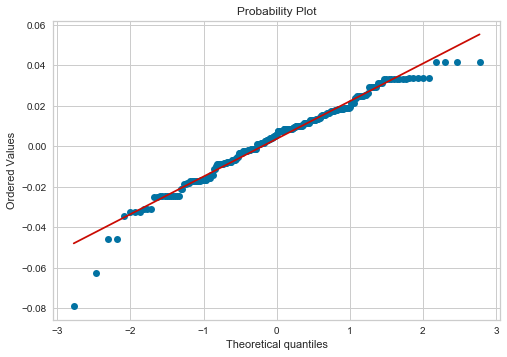

In [685]:
from scipy import stats
# Jarque_bera test
jb = stats.jarque_bera(residuals)
print('Jarque_bera statistic is {} and the p-value is {}'.format(jb[0], jb[1]))
# Shapiro-Wilk test
sw = stats.shapiro(residuals)
print('Shapiro-Wilk statistic is {} and the p-value is {}'.format(sw[0], sw[1]))
# Anderson-Darling test
ad = stats.anderson(residuals, dist = 'norm')
print('Anderson-Darling statistic is {} and the p-values are {}'.format(ad[0], ad[1]))
# Kolmogorov-Smirnov test
ks = stats.kstest(residuals, 'norm')
print('Kolmogorov-Smirnov statistic is {} and the p-value is {}'.format(ks[0], ks[1]))

# Plot Q-Q graph
stats.probplot(residuals, dist = "norm", plot = pylab)
pylab.show()

#### The plot shows that the residuals don´t follow an exact normal distribution. The battery of tests confirm this result. The fact that the normality assumptions does not hold should make us skeptical of the reliability of the model. Because of this reason, we will compare the predictions of the model against the y_test prices we are trying to predict. This allows an empirical comprobation. 


#### 3. Independence of the residuals assumption

#### Same as with the multiple linear regression model and the lasso model, a Durbin-Watson test is implemented to evaluate whether the residuals are indepentent.

In [686]:
db = durbin_watson(residuals, axis = 0)

print('The Durbin_Watson statistics is {}'.format(db))

The Durbin_Watson statistics is 2.006093884126128


#### From the result above we can conclude that our residuals are independent. 

### 4.4 Generate and evaluate the prediction

#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [687]:
# Predict SalePrices with the model.
prediction = cv_ridge.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.0003625572914420627
The root mean squared error (RMSE) is 0.01904093725219593
The mean absolute error (MAE) is 0.015194945897880452


## 5. Gradient Boosting

#### In addition to the linear models implemented above, we also try non-linear, tree-based, models. There may be non-linear relationships in our data that our tree-models are able to capture, perhaps offering better performance that the linear models tried above. We will start by implement gradient boosting and then we will turn to random forest.

#### The steps to follow when implement gradient boosting are:
#### 1. Implement the gradient boosting model and check its R-squared for both the training and testing sets. 
#### 2. Tune the hyperparameters using cross-validation. This process allows to avoid overfitting that may have been suggested in the first step.
#### 3. Perform a prediction using our cross-validated model. Then, this predictions will be evaluated against our prices in the testing dataset (y_test).

### 5.1 Implement the gradient boosting model

In [688]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gbr = ensemble.GradientBoostingRegressor()
gbr.fit(x_train, y_train)

# Check score without cross-validation
print('The training R-squared is {}'.format(gbr.score(x_train, y_train)))
print('The testing R-squared is {}'.format(gbr.score(x_test, y_test)))

The training R-squared is 0.9999978302884553
The testing R-squared is 0.9999955555338944


### 5.2 Tune hyperparameters using cross-validation 

#### The cross-validation shown below is the result of different trials adjusting the hyperparameters. Only the final option has been kept in order to save time when running the code.

In [689]:
# Fit cross-validated
grid_boosting = {'learning_rate':[1], 'n_estimators':[10], 'max_depth': [23], 'criterion':['mae']}
cv_gbr = GridSearchCV(gbr, grid_boosting, cv = 3)
cv_gbr.fit(x_train, y_train)

# Selecting optimal parameters
print('The training R-squared is {}'.format((cv_gbr.score(x_train, y_train))))
print('The testing R-squared is {}'.format(cv_gbr.score(x_test, y_test)))
print('Chosen hyperparameters are: {}'.format(cv_gbr.best_params_))

The training R-squared is 1.0
The testing R-squared is 0.9994247171809938
Chosen hyperparameters are: {'criterion': 'mae', 'learning_rate': 1, 'max_depth': 23, 'n_estimators': 10}


### 5.3 Generate and evaluate the prediction

#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [690]:
# Predict SalePrices with the model.
prediction = cv_gbr.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 3.076103635009107e-05
The root mean squared error (RMSE) is 0.00554626327810816
The mean absolute error (MAE) is 0.0011633940000722056


## 6. Random Forest

#### A random forest model is now implemented. The steps to follow are:
#### 1. Implement the random forest model and check its R-squared for both the training and testing sets. 
#### 2.Tune the hyperparameters using cross-validation. This process allows to avoid overfitting that may have been suggested in the first step.
#### 3. Perform a prediction using the cross-validated model. Then, this predictions will be evaluated against our prices in the testing set (y_test).

### 6.1 Implement the random forest model

In [691]:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.fit(x_train, y_train)

# Check score without cross-validation
print('The training R-squared is {}'.format(randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(randomForest.score(x_test, y_test)))

The training R-squared is 1.0
The testing R-squared is 0.9999744280463323


### 6.2 Tune hyperparameters using cross-validation 

In [692]:
# Fit the cross-validated model
from sklearn.model_selection import GridSearchCV
grid_randomForest = {'n_estimators': [146], 'max_depth': [12.5], 'criterion':['mae']} 
cv_randomForest = GridSearchCV(randomForest, grid_randomForest, cv = 3)
cv_randomForest.fit(x_train, y_train)

# Selecting optimal parameters
print('The training R-squared is {}'.format(cv_randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(cv_randomForest.score(x_test, y_test)))
print('Best parameters are {}'.format(cv_randomForest.best_params_))

The training R-squared is 1.0
The testing R-squared is 0.9999752557586877
Best parameters are {'criterion': 'mae', 'max_depth': 12.5, 'n_estimators': 146}


#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [693]:
# Predict SalePrices with the model.
prediction = cv_randomForest.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 1.323103143907245e-06
The root mean squared error (RMSE) is 0.0011502622065891087
The mean absolute error (MAE) is 0.0002528407527616885


## 7. Summary

#### We plot below the R-squared and the evaluation of the predictiosn from the implemented models to allow for an easier comparison.

In [694]:
print('============================================ LASSO ==============================================================')
print('Training set R-squared is {}'.format(cv_lasso.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_lasso.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_lasso.alpha_))
print('------------------------------------------ Predictions --------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_lasso.predict(x_test)
# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

print('============================================ RIDGE ==============================================================')
print('Training set R-squared is {}'.format(cv_ridge.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_ridge.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_ridge.alpha_))
print('------------------------------------------ Predictions --------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_ridge.predict(x_test)
# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

print('========================================== BOOSTING ============================================================')
print('Training set R-squared is {}'.format(cv_gbr.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_gbr.score(x_test, y_test)))
print('------------------------------------------ Predictions ---------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_gbr.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

print('========================================== RANDOM FOREST ========================================================')
print('The training R-squared is {}'.format(cv_randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(cv_randomForest.score(x_test, y_test)))
print('------------------------------------------ Predictions ---------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_randomForest.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

============================================ LASSO ==============================================================
Training set R-squared is 0.9949419761910346
Testing set R-squared is 0.9957283864164458
Amount of penalization is 0.00020620006020732897
------------------------------------------ Predictions --------------------------------------------------------
The mean squared error (MSE) is 0.0002284081088050638
The root mean squared error (RMSE) is 0.015113176661611013
The mean absolute error (MAE) is 0.011755709123263063
============================================ RIDGE ==============================================================
Training set R-squared is 0.9935403273929024
Testing set R-squared is 0.9932195723740163
Amount of penalization is 8.0
------------------------------------------ Predictions --------------------------------------------------------
The mean squared error (MSE) is 0.0003625572914420627
The root mean squared error (RMSE) is 0.01904093725219593
The mean abs

# Predicting Zillow´s rental price index in different cities

## 1. Phoenix

In [695]:
phoenix = pd.read_csv('phoenix.csv')

In [696]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(phoenix.loc[:,phoenix.columns != '2017-12'], phoenix['2017-12'], test_size = 0.2, random_state = 5)

### 1.1 Missing values

In [697]:
missing_values_featues = x_train.isna().sum().reset_index().rename(columns = {0:'missing_values'})
for feature in list(missing_values_featues[missing_values_featues['missing_values'] > 0].iloc[:,0]):
    # We start at the city level
    x_train[feature] = x_train.groupby('City')[feature].transform(lambda x: x.fillna(x.median()))
    for i in range(0, x_test.shape[0]):
        if x_test['City'].iloc[i] in list(x_train['City'].unique()):
            x_test[feature].iloc[i] = x_train.groupby('City')[feature].median()[x_test['City'].iloc[i]]
        else:
            x_test[feature].iloc[i] = x_train[feature].median()
    # Next we move to the state level
    x_train[feature] = x_train.groupby('State')[feature].transform(lambda x: x.fillna(x.median()))
    for i in range(0, x_test.shape[0]):
        if x_test['State'].iloc[i] in list(x_train['State'].unique()):
            x_test[feature].iloc[i] = x_train.groupby('State')[feature].median()[x_test['State'].iloc[i]]
        else:
            x_test[feature].iloc[i] = x_train[feature].median()

C:\Users\Guillermo\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [698]:
x_train.drop(columns = ['geoid'], inplace = True)
x_test.drop(columns = ['geoid'], inplace = True)
x_train.drop(columns = ['City', 'State'], inplace = True)
x_test.drop(columns = ['City', 'State'], inplace = True)

In [699]:
# Total number of missing values in the training set
print('The number of missing values in the training set is {}.'.format(x_train.isna().sum().sum()))
# Total number of rows with missing values. 
print('The number of rows with missing values in the training set is {}.'.format(x_train.shape[0] - x_train.dropna().shape[0]))

print(' ')

# Total number of missing values in the testing set
print('The number of missing values in the testing set is {}.'.format(x_test.isna().sum().sum()))
# Total number of rows with missing values. 
print('The number of rows with missing values in the testing set is {}.'.format(x_test.shape[0] - x_test.dropna().shape[0]))


The number of missing values in the training set is 0.
The number of rows with missing values in the training set is 0.
 
The number of missing values in the testing set is 0.
The number of rows with missing values in the testing set is 0.


### 1.2 Feature engineering

In [700]:
x_train.drop(columns = ['Metro', 'CountyName', 'RegionID'], inplace = True)
x_test.drop(columns = ['Metro', 'CountyName', 'RegionID'], inplace = True)
x_train.drop(columns = ['do_date'], inplace = True)
x_test.drop(columns = ['do_date'], inplace = True)
x_train.drop(columns = ['Unnamed: 0'], inplace = True)
x_test.drop(columns = ['Unnamed: 0'], inplace = True)
x_train.drop(columns = ['SizeRank'], inplace = True)
x_test.drop(columns = ['SizeRank'], inplace = True)
x_train.drop(columns = ['RegionName'], inplace = True)
x_test.drop(columns = ['RegionName'], inplace = True)
x_train.drop(columns = ['year'], inplace = True)
x_test.drop(columns = ['year'], inplace = True)

# x_train
x_train['female_under_18'] = x_train.female_under_5 + x_train.female_5_to_9 + x_train.female_10_to_14 + x_train.female_15_to_17 + x_train.female_18_to_19
x_train['female_under_60'] = x_train.female_20 + x_train.female_21 + x_train.female_22_to_24 + x_train.female_25_to_29 + x_train.female_30_to_34 + x_train.female_35_to_39 + x_train.female_40_to_44 + x_train.female_45_to_49 + x_train.female_50_to_54 + x_train.female_55_to_59 
x_train['female_over_60'] = x_train.female_60_to_61 + x_train.female_62_to_64 + x_train.female_65_to_66 + x_train.female_67_to_69 + x_train.female_70_to_74 + x_train.female_75_to_79 + x_train.female_80_to_84 + x_train.female_85_and_over
x_test['female_under_18'] = x_test.female_under_5 + x_test.female_5_to_9 + x_test.female_10_to_14 + x_test.female_15_to_17 + x_test.female_18_to_19
x_test['female_under_60'] = x_test.female_20 + x_test.female_21 + x_test.female_22_to_24 + x_test.female_25_to_29 + x_test.female_30_to_34 + x_test.female_35_to_39 + x_test.female_40_to_44 + x_test.female_45_to_49 + x_test.female_50_to_54 + x_test.female_55_to_59 
x_test['female_over_60'] = x_test.female_60_to_61 + x_test.female_62_to_64 + x_test.female_65_to_66 + x_test.female_67_to_69 + x_test.female_70_to_74 + x_test.female_75_to_79 + x_test.female_80_to_84 + x_test.female_85_and_over
# x_train
x_train['male_under_18'] = x_train.male_under_5 + x_train.male_5_to_9 + x_train.male_10_to_14 + x_train.male_15_to_17 + x_train.male_18_to_19
x_train['male_under_60'] = x_train.male_20 + x_train.male_21 + x_train.male_22_to_24 + x_train.male_25_to_29 + x_train.male_30_to_34 + x_train.male_35_to_39 + x_train.male_40_to_44 + x_train.male_45_to_49 + x_train.male_50_to_54 + x_train.male_55_to_59 
x_train['male_over_60'] = x_train.male_60_61 + x_train.male_62_64 + x_train.male_65_to_66 + x_train.male_67_to_69 + x_train.male_70_to_74 + x_train.male_75_to_79 + x_train.male_80_to_84 + x_train.male_85_and_over
# x_test
x_test['male_under_18'] = x_test.male_under_5 + x_test.male_5_to_9 + x_test.male_10_to_14 + x_test.male_15_to_17 + x_test.male_18_to_19
x_test['male_under_60'] = x_test.male_20 + x_test.male_21 + x_test.male_22_to_24 + x_test.male_25_to_29 + x_test.male_30_to_34 + x_test.male_35_to_39 + x_test.male_40_to_44 + x_test.male_45_to_49 + x_test.male_50_to_54 + x_test.male_55_to_59 
x_test['male_over_60'] = x_test.male_60_61 + x_test.male_62_64 + x_test.male_65_to_66 + x_test.male_67_to_69 + x_test.male_70_to_74 + x_test.male_75_to_79 + x_test.male_80_to_84 + x_test.male_85_and_over
# x_train
x_train['under10'] = x_train.rent_under_10_percent
x_train['tento50'] = x_train.rent_40_to_50_percent + x_train.rent_35_to_40_percent + x_train.rent_30_to_35_percent+ x_train.rent_25_to_30_percent + x_train.rent_20_to_25_percent + x_train.rent_15_to_20_percent +x_train.rent_10_to_15_percent
x_train['over50'] = x_train.rent_over_50_percent
x_train['uncomputed'] = x_train.rent_burden_not_computed
# x_test
x_test['under10'] = x_test.rent_under_10_percent
x_test['tento50'] = x_test.rent_40_to_50_percent + x_test.rent_35_to_40_percent + x_test.rent_30_to_35_percent+ x_test.rent_25_to_30_percent + x_test.rent_20_to_25_percent + x_test.rent_15_to_20_percent + x_test.rent_10_to_15_percent
x_test['over50'] = x_test.rent_over_50_percent
x_test['uncomputed'] = x_test.rent_burden_not_computed
# x_train
x_train['small_dwellings'] = x_train.dwellings_1_units_attached + x_train.dwellings_1_units_detached + x_train.dwellings_2_units + x_train.dwellings_3_to_4_units + x_train.dwellings_5_to_9_units
x_train['large_dwellings'] = x_train.dwellings_10_to_19_units + x_train.dwellings_20_to_49_units + x_train.dwellings_50_or_more_units
# x_test
x_test['small_dwellings'] = x_test.dwellings_1_units_attached + x_test.dwellings_1_units_detached + x_test.dwellings_2_units + x_test.dwellings_3_to_4_units + x_test.dwellings_5_to_9_units
x_test['large_dwellings'] = x_test.dwellings_10_to_19_units + x_test.dwellings_20_to_49_units + x_test.dwellings_50_or_more_units
# x_train
x_train['commute_less_than_30'] = x_train.commute_5_9_mins + x_train.commute_less_10_mins + x_train.commute_10_14_mins + x_train.commute_15_19_mins + x_train.commute_20_24_mins + x_train.commute_25_29_mins
x_train['commute_less_than_60'] = x_train.commute_30_34_mins + x_train.commute_35_39_mins + x_train.commute_35_44_mins + x_train.commute_40_44_mins + x_train.commute_45_59_mins
x_train['commute_over_60'] = x_train.commute_60_89_mins + x_train.commute_60_more_mins + x_train.commute_90_more_mins
# x_test
x_test['commute_less_than_30'] = x_test.commute_5_9_mins + x_test.commute_less_10_mins + x_test.commute_10_14_mins + x_test.commute_15_19_mins + x_test.commute_20_24_mins + x_test.commute_25_29_mins
x_test['commute_less_than_60'] = x_test.commute_30_34_mins + x_test.commute_35_39_mins + x_test.commute_35_44_mins + x_test.commute_40_44_mins + x_test.commute_45_59_mins
x_test['commute_over_60'] = x_test.commute_60_89_mins + x_test.commute_60_more_mins + x_test.commute_90_more_mins
# x_train
x_train['income_less_than_60000'] = x_train.income_less_10000 + x_train.income_10000_14999 + x_train.income_15000_19999 + x_train.income_20000_24999 + x_train.income_25000_29999 + x_train.income_30000_34999 + x_train.income_35000_39999 + x_train.income_40000_44999 + x_train.income_45000_49999 + x_train.income_50000_59999
x_train['income_less_than_125000'] = x_train.income_60000_74999 + x_train.income_75000_99999 + x_train.income_100000_124999
x_train['income_over_125000'] = x_train.income_125000_149999 + x_train.income_150000_199999 + x_train.income_200000_or_more
# x_test
x_test['income_less_than_60000'] = x_test.income_less_10000 + x_test.income_10000_14999 + x_test.income_15000_19999 + x_test.income_20000_24999 + x_test.income_25000_29999 + x_test.income_30000_34999 + x_test.income_35000_39999 + x_test.income_40000_44999 + x_test.income_45000_49999 + x_test.income_50000_59999
x_test['income_less_than_125000'] = x_test.income_60000_74999 + x_test.income_75000_99999 + x_test.income_100000_124999
x_test['income_over_125000'] = x_test.income_125000_149999 + x_test.income_150000_199999 + x_test.income_200000_or_more
# x_train
x_train['employed_creative'] = x_train.employed_arts_entertainment_recreation_accommodation_food
x_train['employed_prof'] = x_train.employed_education_health_social + x_train.employed_finance_insurance_real_estate + x_train.employed_information + x_train.employed_science_management_admin_waste
x_train['employed_skill'] = x_train.employed_manufacturing + x_train.employed_construction + x_train.employed_agriculture_forestry_fishing_hunting_mining
x_train['employed_service'] = x_train.employed_retail_trade + x_train.employed_other_services_not_public_admin + x_train.employed_public_administration + x_train.employed_transportation_warehousing_utilities + x_train.employed_wholesale_trade
# x_test
x_test['employed_creative'] = x_test.employed_arts_entertainment_recreation_accommodation_food
x_test['employed_prof'] = x_test.employed_education_health_social + x_test.employed_finance_insurance_real_estate + x_test.employed_information + x_test.employed_science_management_admin_waste
x_test['employed_skill'] = x_test.employed_manufacturing + x_test.employed_construction + x_test.employed_agriculture_forestry_fishing_hunting_mining
x_test['employed_service'] = x_test.employed_retail_trade + x_test.employed_other_services_not_public_admin + x_test.employed_public_administration + x_test.employed_transportation_warehousing_utilities + x_test.employed_wholesale_trade
# x_train
x_train['college_educated'] = x_train.in_undergrad_college + x_train.some_college_and_associates_degree + x_train.associates_degree + x_train.bachelors_degree + x_train.bachelors_degree_2 + x_train.bachelors_degree_or_higher_25_64 + x_train.masters_degree + x_train.graduate_professional_degree + x_train.one_year_more_college     
x_train['in_school'] = x_train.in_grades_1_to_4 + x_train.in_grades_5_to_8 + x_train.in_grades_9_to_12
x_train['inschoolcheck'] = x_train.in_school
x_train['less_than_college_educated'] = x_train.less_one_year_college + x_train.less_one_year_college
x_train['high_school_educated'] = x_train.high_school_diploma + x_train.high_school_including_ged
# x_test
x_test['college_educated'] = x_test.in_undergrad_college + x_test.some_college_and_associates_degree + x_test.associates_degree + x_test.bachelors_degree + x_test.bachelors_degree_2 + x_test.bachelors_degree_or_higher_25_64 + x_test.masters_degree + x_test.graduate_professional_degree + x_test.one_year_more_college     
x_test['in_school'] = x_test.in_grades_1_to_4 + x_test.in_grades_5_to_8 + x_test.in_grades_9_to_12
x_test['inschoolcheck'] = x_test.in_school
x_test['less_than_college_educated'] = x_test.less_one_year_college + x_test.less_one_year_college
x_test['high_school_educated'] = x_test.high_school_diploma + x_test.high_school_including_ged
# x_train
x_train['public_commute'] = x_train.commuters_by_public_transportation + x_train.commuters_by_subway_or_elevated + x_train.commuters_by_bus
x_train['personal_commute'] = x_train.commuters_by_car_truck_van + x_train.commuters_by_carpool + x_train.commuters_drove_alone
# x_test
x_test['public_commute'] = x_test.commuters_by_public_transportation + x_test.commuters_by_subway_or_elevated + x_test.commuters_by_bus
x_test['personal_commute'] = x_test.commuters_by_car_truck_van + x_test.commuters_by_carpool + x_test.commuters_drove_alone
# x_train
x_train['two_parent_hh'] = x_train.two_parent_families_with_young_children.astype(float)
x_train['one_parent_hh'] = x_train.one_parent_families_with_young_children.astype(float)
# x_test
x_test['two_parent_hh'] = x_test.two_parent_families_with_young_children.astype(float)
x_test['one_parent_hh'] = x_test.one_parent_families_with_young_children.astype(float)

x_train = x_train[['2015-12','gini_index', 'income_per_capita', 'median_age', 'median_income', 'married_households', 'family_households', 
                   'nonfamily_households', 'unemployed_pop', 'employed_pop', 'owner_occupied_housing_units',
                   'owner_occupied_housing_units_lower_value_quartile','owner_occupied_housing_units_median_value',
                   'owner_occupied_housing_units_upper_value_quartile','vacant_housing_units', 'vacant_housing_units_for_rent',
                   'vacant_housing_units_for_sale', 'public_commute', 'personal_commute','college_educated', 'in_school', 
                   'less_than_college_educated','high_school_educated', 'asian_pop', 'amerindian_pop', 'black_pop',
                   'hispanic_pop', 'white_pop', 'amerindian_including_hispanic', 'other_race_pop', 'two_or_more_races_pop', 
                   'two_parent_hh', 'one_parent_hh', 'employed_creative', 'employed_prof', 'employed_skill','employed_service', 
                   'income_less_than_60000', 'income_less_than_125000','income_over_125000', 'commute_less_than_30', 
                   'commute_less_than_60','commute_over_60', 'small_dwellings', 'large_dwellings', 'male_under_18',
                   'male_under_60', 'male_over_60', 'female_under_18', 'female_under_60','female_over_60']]

x_test = x_test[['2015-12','gini_index', 'income_per_capita', 'median_age', 'median_income', 'married_households', 'family_households', 
                   'nonfamily_households', 'unemployed_pop', 'employed_pop', 'owner_occupied_housing_units',
                   'owner_occupied_housing_units_lower_value_quartile','owner_occupied_housing_units_median_value',
                   'owner_occupied_housing_units_upper_value_quartile','vacant_housing_units', 'vacant_housing_units_for_rent',
                   'vacant_housing_units_for_sale', 'public_commute', 'personal_commute','college_educated', 'in_school', 
                   'less_than_college_educated','high_school_educated', 'asian_pop', 'amerindian_pop', 'black_pop',
                   'hispanic_pop', 'white_pop', 'amerindian_including_hispanic', 'other_race_pop', 'two_or_more_races_pop', 
                   'two_parent_hh', 'one_parent_hh', 'employed_creative', 'employed_prof', 'employed_skill','employed_service', 
                   'income_less_than_60000', 'income_less_than_125000','income_over_125000', 'commute_less_than_30', 
                   'commute_less_than_60','commute_over_60', 'small_dwellings', 'large_dwellings', 'male_under_18',
                   'male_under_60', 'male_over_60', 'female_under_18', 'female_under_60','female_over_60']]

for feature in x_train.columns:
    x_train[feature] = x_train[feature].astype(float)
for feature in x_train.columns:
    x_train[feature] = x_train[feature].astype(float) 

### 1.3 Yeo-Johnson transformation

In [701]:
from sklearn.preprocessing import PowerTransformer
    
pt = PowerTransformer(method = 'yeo-johnson')
for feature in list(x_train.select_dtypes(include = ['int64', 'float64'])):
    x_train[feature] = pt.fit_transform(x_train[feature].to_numpy().reshape(-1,1))
    x_test[feature] = pt.transform(x_test[feature].to_numpy().reshape(-1,1)) 

### 1.4 Logarithmic transformation of the dependent variable

In [702]:
y_train = y_train.apply(lambda x: np.log(x))
y_test = y_test.apply(lambda x: np.log(x))

### 1.5 Lasso predictions

In [703]:
# Predict SalePrices with the model.
prediction = cv_lasso.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.018636056025927546
The root mean squared error (RMSE) is 0.13651394077502688
The mean absolute error (MAE) is 0.12109736889997652


### 1.6 Ridge predictions

In [704]:
# Predict SalePrices with the model.
prediction = cv_ridge.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.01739719566345267
The root mean squared error (RMSE) is 0.13189842934414597
The mean absolute error (MAE) is 0.11975837476957504


### 1.7 Gradient boosting predictions

In [705]:
# Predict SalePrices with the model.
prediction = cv_gbr.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.019506100583964753
The root mean squared error (RMSE) is 0.13966424232409938
The mean absolute error (MAE) is 0.11940811379153825


### 1.8 Random forest predictions

In [706]:
# Predict SalePrices with the model.
prediction = cv_randomForest.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.019617425080912368
The root mean squared error (RMSE) is 0.14006221860627643
The mean absolute error (MAE) is 0.1254307127368007


# Predicting Zillow´s rental price index without historic data

### 1. Import data

In [707]:
tampa = pd.read_csv('tampa.csv')

### 2. Split dataframe

In [708]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tampa.loc[:,tampa.columns != '2017-12'], tampa['2017-12'], test_size = 0.2, random_state = 5)

### 3. Missing values

In [709]:
missing_values_featues = x_train.isna().sum().reset_index().rename(columns = {0:'missing_values'})
for feature in list(missing_values_featues[missing_values_featues['missing_values'] > 0].iloc[:,0]):
    # We start at the city level
    x_train[feature] = x_train.groupby('City')[feature].transform(lambda x: x.fillna(x.median()))
    for i in range(0, x_test.shape[0]):
        if x_test['City'].iloc[i] in list(x_train['City'].unique()):
            x_test[feature].iloc[i] = x_train.groupby('City')[feature].median()[x_test['City'].iloc[i]]
        else:
            x_test[feature].iloc[i] = x_train[feature].median()
    # Next we move to the state level
    x_train[feature] = x_train.groupby('State')[feature].transform(lambda x: x.fillna(x.median()))
    for i in range(0, x_test.shape[0]):
        if x_test['State'].iloc[i] in list(x_train['State'].unique()):
            x_test[feature].iloc[i] = x_train.groupby('State')[feature].median()[x_test['State'].iloc[i]]
        else:
            x_test[feature].iloc[i] = x_train[feature].median()

C:\Users\Guillermo\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [710]:
x_train.drop(columns = ['geoid'], inplace = True)
x_test.drop(columns = ['geoid'], inplace = True)
x_train.drop(columns = ['City', 'State'], inplace = True)
x_test.drop(columns = ['City', 'State'], inplace = True)

In [711]:
# Total number of missing values in the training set
print('The number of missing values in the training set is {}.'.format(x_train.isna().sum().sum()))
# Total number of rows with missing values. 
print('The number of rows with missing values in the training set is {}.'.format(x_train.shape[0] - x_train.dropna().shape[0]))

print(' ')

# Total number of missing values in the testing set
print('The number of missing values in the testing set is {}.'.format(x_test.isna().sum().sum()))
# Total number of rows with missing values. 
print('The number of rows with missing values in the testing set is {}.'.format(x_test.shape[0] - x_test.dropna().shape[0]))


The number of missing values in the training set is 0.
The number of rows with missing values in the training set is 0.
 
The number of missing values in the testing set is 0.
The number of rows with missing values in the testing set is 0.


### 4. Feature engineering

In [712]:
x_train.drop(columns = ['Metro', 'CountyName', 'RegionID'], inplace = True)
x_test.drop(columns = ['Metro', 'CountyName', 'RegionID'], inplace = True)
x_train.drop(columns = ['do_date'], inplace = True)
x_test.drop(columns = ['do_date'], inplace = True)
x_train.drop(columns = ['Unnamed: 0'], inplace = True)
x_test.drop(columns = ['Unnamed: 0'], inplace = True)
x_train.drop(columns = ['SizeRank'], inplace = True)
x_test.drop(columns = ['SizeRank'], inplace = True)
x_train.drop(columns = ['RegionName'], inplace = True)
x_test.drop(columns = ['RegionName'], inplace = True)
x_train.drop(columns = ['year'], inplace = True)
x_test.drop(columns = ['year'], inplace = True)

# x_train
x_train['female_under_18'] = x_train.female_under_5 + x_train.female_5_to_9 + x_train.female_10_to_14 + x_train.female_15_to_17 + x_train.female_18_to_19
x_train['female_under_60'] = x_train.female_20 + x_train.female_21 + x_train.female_22_to_24 + x_train.female_25_to_29 + x_train.female_30_to_34 + x_train.female_35_to_39 + x_train.female_40_to_44 + x_train.female_45_to_49 + x_train.female_50_to_54 + x_train.female_55_to_59 
x_train['female_over_60'] = x_train.female_60_to_61 + x_train.female_62_to_64 + x_train.female_65_to_66 + x_train.female_67_to_69 + x_train.female_70_to_74 + x_train.female_75_to_79 + x_train.female_80_to_84 + x_train.female_85_and_over
x_test['female_under_18'] = x_test.female_under_5 + x_test.female_5_to_9 + x_test.female_10_to_14 + x_test.female_15_to_17 + x_test.female_18_to_19
x_test['female_under_60'] = x_test.female_20 + x_test.female_21 + x_test.female_22_to_24 + x_test.female_25_to_29 + x_test.female_30_to_34 + x_test.female_35_to_39 + x_test.female_40_to_44 + x_test.female_45_to_49 + x_test.female_50_to_54 + x_test.female_55_to_59 
x_test['female_over_60'] = x_test.female_60_to_61 + x_test.female_62_to_64 + x_test.female_65_to_66 + x_test.female_67_to_69 + x_test.female_70_to_74 + x_test.female_75_to_79 + x_test.female_80_to_84 + x_test.female_85_and_over
# x_train
x_train['male_under_18'] = x_train.male_under_5 + x_train.male_5_to_9 + x_train.male_10_to_14 + x_train.male_15_to_17 + x_train.male_18_to_19
x_train['male_under_60'] = x_train.male_20 + x_train.male_21 + x_train.male_22_to_24 + x_train.male_25_to_29 + x_train.male_30_to_34 + x_train.male_35_to_39 + x_train.male_40_to_44 + x_train.male_45_to_49 + x_train.male_50_to_54 + x_train.male_55_to_59 
x_train['male_over_60'] = x_train.male_60_61 + x_train.male_62_64 + x_train.male_65_to_66 + x_train.male_67_to_69 + x_train.male_70_to_74 + x_train.male_75_to_79 + x_train.male_80_to_84 + x_train.male_85_and_over
# x_test
x_test['male_under_18'] = x_test.male_under_5 + x_test.male_5_to_9 + x_test.male_10_to_14 + x_test.male_15_to_17 + x_test.male_18_to_19
x_test['male_under_60'] = x_test.male_20 + x_test.male_21 + x_test.male_22_to_24 + x_test.male_25_to_29 + x_test.male_30_to_34 + x_test.male_35_to_39 + x_test.male_40_to_44 + x_test.male_45_to_49 + x_test.male_50_to_54 + x_test.male_55_to_59 
x_test['male_over_60'] = x_test.male_60_61 + x_test.male_62_64 + x_test.male_65_to_66 + x_test.male_67_to_69 + x_test.male_70_to_74 + x_test.male_75_to_79 + x_test.male_80_to_84 + x_test.male_85_and_over
# x_train
x_train['under10'] = x_train.rent_under_10_percent
x_train['tento50'] = x_train.rent_40_to_50_percent + x_train.rent_35_to_40_percent + x_train.rent_30_to_35_percent+ x_train.rent_25_to_30_percent + x_train.rent_20_to_25_percent + x_train.rent_15_to_20_percent +x_train.rent_10_to_15_percent
x_train['over50'] = x_train.rent_over_50_percent
x_train['uncomputed'] = x_train.rent_burden_not_computed
# x_test
x_test['under10'] = x_test.rent_under_10_percent
x_test['tento50'] = x_test.rent_40_to_50_percent + x_test.rent_35_to_40_percent + x_test.rent_30_to_35_percent+ x_test.rent_25_to_30_percent + x_test.rent_20_to_25_percent + x_test.rent_15_to_20_percent + x_test.rent_10_to_15_percent
x_test['over50'] = x_test.rent_over_50_percent
x_test['uncomputed'] = x_test.rent_burden_not_computed
# x_train
x_train['small_dwellings'] = x_train.dwellings_1_units_attached + x_train.dwellings_1_units_detached + x_train.dwellings_2_units + x_train.dwellings_3_to_4_units + x_train.dwellings_5_to_9_units
x_train['large_dwellings'] = x_train.dwellings_10_to_19_units + x_train.dwellings_20_to_49_units + x_train.dwellings_50_or_more_units
# x_test
x_test['small_dwellings'] = x_test.dwellings_1_units_attached + x_test.dwellings_1_units_detached + x_test.dwellings_2_units + x_test.dwellings_3_to_4_units + x_test.dwellings_5_to_9_units
x_test['large_dwellings'] = x_test.dwellings_10_to_19_units + x_test.dwellings_20_to_49_units + x_test.dwellings_50_or_more_units
# x_train
x_train['commute_less_than_30'] = x_train.commute_5_9_mins + x_train.commute_less_10_mins + x_train.commute_10_14_mins + x_train.commute_15_19_mins + x_train.commute_20_24_mins + x_train.commute_25_29_mins
x_train['commute_less_than_60'] = x_train.commute_30_34_mins + x_train.commute_35_39_mins + x_train.commute_35_44_mins + x_train.commute_40_44_mins + x_train.commute_45_59_mins
x_train['commute_over_60'] = x_train.commute_60_89_mins + x_train.commute_60_more_mins + x_train.commute_90_more_mins
# x_test
x_test['commute_less_than_30'] = x_test.commute_5_9_mins + x_test.commute_less_10_mins + x_test.commute_10_14_mins + x_test.commute_15_19_mins + x_test.commute_20_24_mins + x_test.commute_25_29_mins
x_test['commute_less_than_60'] = x_test.commute_30_34_mins + x_test.commute_35_39_mins + x_test.commute_35_44_mins + x_test.commute_40_44_mins + x_test.commute_45_59_mins
x_test['commute_over_60'] = x_test.commute_60_89_mins + x_test.commute_60_more_mins + x_test.commute_90_more_mins
# x_train
x_train['income_less_than_60000'] = x_train.income_less_10000 + x_train.income_10000_14999 + x_train.income_15000_19999 + x_train.income_20000_24999 + x_train.income_25000_29999 + x_train.income_30000_34999 + x_train.income_35000_39999 + x_train.income_40000_44999 + x_train.income_45000_49999 + x_train.income_50000_59999
x_train['income_less_than_125000'] = x_train.income_60000_74999 + x_train.income_75000_99999 + x_train.income_100000_124999
x_train['income_over_125000'] = x_train.income_125000_149999 + x_train.income_150000_199999 + x_train.income_200000_or_more
# x_test
x_test['income_less_than_60000'] = x_test.income_less_10000 + x_test.income_10000_14999 + x_test.income_15000_19999 + x_test.income_20000_24999 + x_test.income_25000_29999 + x_test.income_30000_34999 + x_test.income_35000_39999 + x_test.income_40000_44999 + x_test.income_45000_49999 + x_test.income_50000_59999
x_test['income_less_than_125000'] = x_test.income_60000_74999 + x_test.income_75000_99999 + x_test.income_100000_124999
x_test['income_over_125000'] = x_test.income_125000_149999 + x_test.income_150000_199999 + x_test.income_200000_or_more
# x_train
x_train['employed_creative'] = x_train.employed_arts_entertainment_recreation_accommodation_food
x_train['employed_prof'] = x_train.employed_education_health_social + x_train.employed_finance_insurance_real_estate + x_train.employed_information + x_train.employed_science_management_admin_waste
x_train['employed_skill'] = x_train.employed_manufacturing + x_train.employed_construction + x_train.employed_agriculture_forestry_fishing_hunting_mining
x_train['employed_service'] = x_train.employed_retail_trade + x_train.employed_other_services_not_public_admin + x_train.employed_public_administration + x_train.employed_transportation_warehousing_utilities + x_train.employed_wholesale_trade
# x_test
x_test['employed_creative'] = x_test.employed_arts_entertainment_recreation_accommodation_food
x_test['employed_prof'] = x_test.employed_education_health_social + x_test.employed_finance_insurance_real_estate + x_test.employed_information + x_test.employed_science_management_admin_waste
x_test['employed_skill'] = x_test.employed_manufacturing + x_test.employed_construction + x_test.employed_agriculture_forestry_fishing_hunting_mining
x_test['employed_service'] = x_test.employed_retail_trade + x_test.employed_other_services_not_public_admin + x_test.employed_public_administration + x_test.employed_transportation_warehousing_utilities + x_test.employed_wholesale_trade
# x_train
x_train['college_educated'] = x_train.in_undergrad_college + x_train.some_college_and_associates_degree + x_train.associates_degree + x_train.bachelors_degree + x_train.bachelors_degree_2 + x_train.bachelors_degree_or_higher_25_64 + x_train.masters_degree + x_train.graduate_professional_degree + x_train.one_year_more_college     
x_train['in_school'] = x_train.in_grades_1_to_4 + x_train.in_grades_5_to_8 + x_train.in_grades_9_to_12
x_train['inschoolcheck'] = x_train.in_school
x_train['less_than_college_educated'] = x_train.less_one_year_college + x_train.less_one_year_college
x_train['high_school_educated'] = x_train.high_school_diploma + x_train.high_school_including_ged
# x_test
x_test['college_educated'] = x_test.in_undergrad_college + x_test.some_college_and_associates_degree + x_test.associates_degree + x_test.bachelors_degree + x_test.bachelors_degree_2 + x_test.bachelors_degree_or_higher_25_64 + x_test.masters_degree + x_test.graduate_professional_degree + x_test.one_year_more_college     
x_test['in_school'] = x_test.in_grades_1_to_4 + x_test.in_grades_5_to_8 + x_test.in_grades_9_to_12
x_test['inschoolcheck'] = x_test.in_school
x_test['less_than_college_educated'] = x_test.less_one_year_college + x_test.less_one_year_college
x_test['high_school_educated'] = x_test.high_school_diploma + x_test.high_school_including_ged
# x_train
x_train['public_commute'] = x_train.commuters_by_public_transportation + x_train.commuters_by_subway_or_elevated + x_train.commuters_by_bus
x_train['personal_commute'] = x_train.commuters_by_car_truck_van + x_train.commuters_by_carpool + x_train.commuters_drove_alone
# x_test
x_test['public_commute'] = x_test.commuters_by_public_transportation + x_test.commuters_by_subway_or_elevated + x_test.commuters_by_bus
x_test['personal_commute'] = x_test.commuters_by_car_truck_van + x_test.commuters_by_carpool + x_test.commuters_drove_alone
# x_train
x_train['two_parent_hh'] = x_train.two_parent_families_with_young_children.astype(float)
x_train['one_parent_hh'] = x_train.one_parent_families_with_young_children.astype(float)
# x_test
x_test['two_parent_hh'] = x_test.two_parent_families_with_young_children.astype(float)
x_test['one_parent_hh'] = x_test.one_parent_families_with_young_children.astype(float)

x_train = x_train[['gini_index', 'income_per_capita', 'median_age', 'median_income', 'married_households', 'family_households', 
                   'nonfamily_households', 'unemployed_pop', 'employed_pop', 'owner_occupied_housing_units',
                   'owner_occupied_housing_units_lower_value_quartile','owner_occupied_housing_units_median_value',
                   'owner_occupied_housing_units_upper_value_quartile','vacant_housing_units', 'vacant_housing_units_for_rent',
                   'vacant_housing_units_for_sale', 'public_commute', 'personal_commute','college_educated', 'in_school', 
                   'less_than_college_educated','high_school_educated', 'asian_pop', 'amerindian_pop', 'black_pop',
                   'hispanic_pop', 'white_pop', 'amerindian_including_hispanic', 'other_race_pop', 'two_or_more_races_pop', 
                   'two_parent_hh', 'one_parent_hh', 'employed_creative', 'employed_prof', 'employed_skill','employed_service', 
                   'income_less_than_60000', 'income_less_than_125000','income_over_125000', 'commute_less_than_30', 
                   'commute_less_than_60','commute_over_60', 'small_dwellings', 'large_dwellings', 'male_under_18',
                   'male_under_60', 'male_over_60', 'female_under_18', 'female_under_60','female_over_60']]

x_test = x_test[['gini_index', 'income_per_capita', 'median_age', 'median_income', 'married_households', 'family_households', 
                   'nonfamily_households', 'unemployed_pop', 'employed_pop', 'owner_occupied_housing_units',
                   'owner_occupied_housing_units_lower_value_quartile','owner_occupied_housing_units_median_value',
                   'owner_occupied_housing_units_upper_value_quartile','vacant_housing_units', 'vacant_housing_units_for_rent',
                   'vacant_housing_units_for_sale', 'public_commute', 'personal_commute','college_educated', 'in_school', 
                   'less_than_college_educated','high_school_educated', 'asian_pop', 'amerindian_pop', 'black_pop',
                   'hispanic_pop', 'white_pop', 'amerindian_including_hispanic', 'other_race_pop', 'two_or_more_races_pop', 
                   'two_parent_hh', 'one_parent_hh', 'employed_creative', 'employed_prof', 'employed_skill','employed_service', 
                   'income_less_than_60000', 'income_less_than_125000','income_over_125000', 'commute_less_than_30', 
                   'commute_less_than_60','commute_over_60', 'small_dwellings', 'large_dwellings', 'male_under_18',
                   'male_under_60', 'male_over_60', 'female_under_18', 'female_under_60','female_over_60']]

for feature in x_train.columns:
    x_train[feature] = x_train[feature].astype(float)
for feature in x_train.columns:
    x_train[feature] = x_train[feature].astype(float) 

### 5. Yeo-Johnson transformation

In [713]:
from sklearn.preprocessing import PowerTransformer
    
pt = PowerTransformer(method = 'yeo-johnson')
for feature in list(x_train.select_dtypes(include = ['int64', 'float64'])):
    x_train[feature] = pt.fit_transform(x_train[feature].to_numpy().reshape(-1,1))
    x_test[feature] = pt.transform(x_test[feature].to_numpy().reshape(-1,1)) 

C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.

### 6. Logarithmic transformation of the dependent variable

In [714]:
y_train = y_train.apply(lambda x: np.log(x))
y_test = y_test.apply(lambda x: np.log(x))

### 7. Lasso regression

In [736]:
from sklearn.linear_model import LassoCV
cv_lasso = LassoCV(n_alphas = 200, cv = 10, max_iter = 2000, fit_intercept = True) 
cv_lasso.fit(x_train, y_train)

# Check Lasso´s performance and best parameters as outcomes of cross validation.
print('Training set R-squared is {}'.format(cv_lasso.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_lasso.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_lasso.alpha_))

Training set R-squared is 0.9872133453620531
Testing set R-squared is 0.9891908048255517
Amount of penalization is 134.83558046554026


In [716]:
# Predict SalePrices with the model.
prediction = cv_lasso.predict(x_test)

# Check accuracy with MSE
from sklearn.metrics import mean_squared_error
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
from sklearn.metrics import mean_absolute_error
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.0019254528983075059
The root mean squared error (RMSE) is 0.0438799828886419
The mean absolute error (MAE) is 0.03704814160797872


### 8. Ridge regression

In [717]:
from sklearn.linear_model import RidgeCV
cv_ridge = RidgeCV(alphas = np.linspace(8, 100, 100), cv = 3, normalize = False, fit_intercept = True)
cv_ridge.fit(x_train, y_train)

# Check Ridge best parameters as outcomes of cross validation.
print('Training set R-squared is {}'.format(cv_ridge.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_ridge.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_ridge.alpha_))

Training set R-squared is 0.9794548729463497
Testing set R-squared is 0.9691167734537862
Amount of penalization is 8.0


In [718]:
# Predict SalePrices with the model.
prediction = cv_ridge.predict(x_test)

# Check accuracy with MSE
from sklearn.metrics import mean_squared_error
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
from sklearn.metrics import mean_absolute_error
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.0016513617702633152
The root mean squared error (RMSE) is 0.0406369507992826
The mean absolute error (MAE) is 0.032759077377760445


### 9. Gradient boosting

In [719]:
# Fit cross-validated
grid_boosting = {'learning_rate':[1], 'n_estimators':range(9, 15) 'max_depth': [50.5], 'criterion':['mae']}
cv_gbr = GridSearchCV(gbr, grid_boosting, cv = 3)
cv_gbr.fit(x_train, y_train)

# Selecting optimal parameters
print('The training R-squared is {}'.format((cv_gbr.score(x_train, y_train))))
print('The testing R-squared is {}'.format(cv_gbr.score(x_test, y_test)))
print('Chosen hyperparameters are: {}'.format(cv_gbr.best_params_))

The training R-squared is 1.0
The testing R-squared is 0.9928610307716612
Chosen hyperparameters are: {'criterion': 'mae', 'learning_rate': 1.0, 'max_depth': 50.5, 'n_estimators': 10}


In [720]:
# Predict SalePrices with the model.
prediction = cv_gbr.predict(x_test)

# Check accuracy with MSE
from sklearn.metrics import mean_squared_error
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
from sklearn.metrics import mean_absolute_error
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.0003817289247651555
The root mean squared error (RMSE) is 0.019537884347215168
The mean absolute error (MAE) is 0.002899281093069064


### 10. Random forest

In [721]:
# Fit the cross-validated model
from sklearn.model_selection import GridSearchCV
grid_randomForest = {'n_estimators': range(205,212), 'max_depth': [50], 'criterion':['mae']} 
cv_randomForest = GridSearchCV(randomForest, grid_randomForest, cv = 3)
cv_randomForest.fit(x_train, y_train)

# Selecting optimal parameters
print('The training R-squared is {}'.format(cv_randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(cv_randomForest.score(x_test, y_test)))
print('Best parameters are {}'.format(cv_randomForest.best_params_))

The training R-squared is 0.9999999943668283
The testing R-squared is 0.9997932727027853
Best parameters are {'criterion': 'mae', 'max_depth': 50.0, 'n_estimators': 210}


In [722]:
# Predict SalePrices with the model.
prediction = cv_randomForest.predict(x_test)

# Check accuracy with MSE
from sklearn.metrics import mean_squared_error
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
from sklearn.metrics import mean_absolute_error
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 1.1053947196202873e-05
The root mean squared error (RMSE) is 0.0033247476891040727
The mean absolute error (MAE) is 0.0008913324895708499


# Predicting Zillow´s rental price index using only historic data

### 1. Import dataframe

In [723]:
tampa = pd.read_csv('tampa.csv')

### 2. Split dataframe 

In [724]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tampa.loc[:,tampa.columns != '2017-12'], tampa['2017-12'], test_size = 0.2, random_state = 5)

### 3. Feature engineering: keep historic data.

In [725]:
x_train = x_train[['2015-12']]
x_test = x_test[['2015-12']]

### 4. Lasso regression

In [726]:
from sklearn.linear_model import LassoCV
cv_lasso = LassoCV(n_alphas = 200, cv = 10, max_iter = 1500, fit_intercept = True) 
cv_lasso.fit(x_train, y_train)

# Check Lasso´s performance and best parameters as outcomes of cross validation.
print('Training set R-squared is {}'.format(cv_lasso.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_lasso.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_lasso.alpha_))

Training set R-squared is 0.9872133453620531
Testing set R-squared is 0.9891908048255517
Amount of penalization is 134.83558046554026


In [727]:
# Predict SalePrices with the model.
prediction = cv_lasso.predict(x_test)

# Check accuracy with MSE
from sklearn.metrics import mean_squared_error
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
from sklearn.metrics import mean_absolute_error
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 1698.984164622109
The root mean squared error (RMSE) is 41.2187356019336
The mean absolute error (MAE) is 30.93984949360702


### 5. Ridge regression

In [728]:
from sklearn.linear_model import RidgeCV
cv_ridge = RidgeCV(alphas = np.linspace(8, 100, 100), cv = 3, normalize = False, fit_intercept = True)
cv_ridge.fit(x_train, y_train)

# Check Ridge best parameters as outcomes of cross validation.
print('Training set R-squared is {}'.format(cv_ridge.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_ridge.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_ridge.alpha_))

Training set R-squared is 0.9872143325763825
Testing set R-squared is 0.9891634807823998
Amount of penalization is 8.0


In [729]:
# Predict SalePrices with the model.
prediction = cv_ridge.predict(x_test)

# Check accuracy with MSE
from sklearn.metrics import mean_squared_error
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
from sklearn.metrics import mean_absolute_error
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 1703.2789447495459
The root mean squared error (RMSE) is 41.270800146708396
The mean absolute error (MAE) is 30.921507002562002


### 6. Gradient Boosting

In [730]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gbr = ensemble.GradientBoostingRegressor()
gbr.fit(x_train, y_train)

# Check score without cross-validation
print('The training R-squared is {}'.format(gbr.score(x_train, y_train)))
print('The testing R-squared is {}'.format(gbr.score(x_test, y_test)))

The training R-squared is 0.9999998436494129
The testing R-squared is 0.9999998393535978


In [731]:
# Fit cross-validated
grid_boosting = {'learning_rate':[0.1], 'n_estimators':range(209,214), 'max_depth': [50.5], 'criterion':['mae']}
cv_gbr = GridSearchCV(gbr, grid_boosting, cv = 3)
cv_gbr.fit(x_train, y_train)

# Selecting optimal parameters
print('The training R-squared is {}'.format((cv_gbr.score(x_train, y_train))))
print('The testing R-squared is {}'.format(cv_gbr.score(x_test, y_test)))
print('Chosen hyperparameters are: {}'.format(cv_gbr.best_params_))

The training R-squared is 1.0
The testing R-squared is 1.0
Chosen hyperparameters are: {'criterion': 'mae', 'learning_rate': 0.1, 'max_depth': 50.5, 'n_estimators': 210}


In [732]:
# Predict SalePrices with the model.
prediction = cv_gbr.predict(x_test)

# Check accuracy with MSE
from sklearn.metrics import mean_squared_error
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
from sklearn.metrics import mean_absolute_error
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 2.511663684676221e-14
The root mean squared error (RMSE) is 1.584822919027934e-07
The mean absolute error (MAE) is 1.1947713392146397e-07


### 7. Random Forest

In [733]:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.fit(x_train, y_train)

# Check score without cross-validation
print('The training R-squared is {}'.format(randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(randomForest.score(x_test, y_test)))

The training R-squared is 1.0
The testing R-squared is 1.0


In [734]:
# Fit the cross-validated model
from sklearn.model_selection import GridSearchCV
grid_randomForest = {'n_estimators': range(9,12), 'max_depth': [10], 'criterion':['mae']} 
cv_randomForest = GridSearchCV(randomForest, grid_randomForest, cv = 3)
cv_randomForest.fit(x_train, y_train)

# Selecting optimal parameters
print('The training R-squared is {}'.format(cv_randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(cv_randomForest.score(x_test, y_test)))
print('Best parameters are {}'.format(cv_randomForest.best_params_))

The training R-squared is 1.0
The testing R-squared is 1.0
Best parameters are {'criterion': 'mae', 'max_depth': 10.0, 'n_estimators': 10}


In [735]:
# Predict SalePrices with the model.
prediction = cv_randomForest.predict(x_test)

# Check accuracy with MSE
from sklearn.metrics import mean_squared_error
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
from sklearn.metrics import mean_absolute_error
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.0
The root mean squared error (RMSE) is 0.0
The mean absolute error (MAE) is 0.0
